# Analysis reproduction notebook for "MeerKAT discovery of radio emission from the Vela X-1 bow shock" by Van den Eijnden et al.

## Step 1: loading python packages and basic plotting settings

This code uses the following python packages and versions:

numpy v1.15.4

matplotlib v2.2.3

aplpy v1.1.1

scipy v1.1.0

astropy v2.0.9


#### Setting the path for the font to use in plotting labels and texts:

In [1]:
# Make sure to change this path to your local version, or otherwise comment out the noted line in the next cell
path = '/Library/Fonts/Times New Roman.ttf'

#### Loading the packages and setting up plots

In [11]:
import numpy as np
import numpy.ma as ma

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as font_manager
import matplotlib.gridspec as gridspec
import aplpy

from scipy import interpolate
from scipy import optimize
from scipy.integrate import quad
import scipy.special

import os
from astropy import units as u
from astropy.units import cds
from matplotlib import colors
cds.enable()  

# If the font should not be changed, comment out the next two lines:
prop = font_manager.FontProperties(fname=path)
mpl.rcParams['font.family'] = prop.get_name()
mpl.rcParams['pdf.fonttype']=42

params = {'text.usetex':False, 'mathtext.fontset':'custom', 'mathtext.default':'regular'}
mpl.rcParams.update(params)

single_col = 8.9 # cm
double_col = 18.3 # cm
def cm2inch(value):
    return value/2.54
FS = 22
LS = 22
MS = 14
MEW= 1.5

%matplotlib inline

## Step 2: Plotting the ThunderKAT data and the zoom around the bow shock:

#### Recreating Figure 1: the entire field of view

INFO: Setting slices=[0, 0] [aplpy.core]


/Users/jakobvandeneijnden/anaconda3/envs/python2/lib/python2.7/site-packages/aplpy/labels.py:432: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if self.coord == x or self.axis.apl_tick_positions_world[ipos] > 0:
/Users/jakobvandeneijnden/anaconda3/envs/python2/lib/python2.7/site-packages/aplpy/normalize.py:115: RuntimeWarning: invalid value encountered in less
  negative = result < 0.
/Users/jakobvandeneijnden/anaconda3/envs/python2/lib/python2.7/site-packages/matplotlib/axes/_base.py:3152: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-0.5, right=-0.5
  'left=%s, right=%s') % (left, right))
/Users/jakobvandeneijnden/anaconda3/envs/python2/lib/python2.7/site-packages/matplotlib/axis.py:1086: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable t

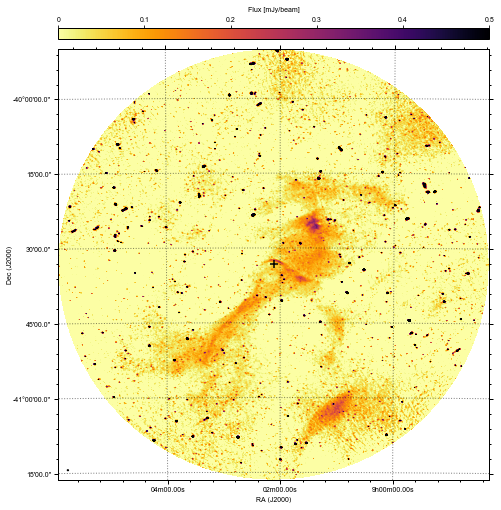

In [3]:
# Set the colormap
CM = 'inferno_r' # binary

# Define the .fits file with the image
data = "Figure1_2/VelaX-1_3MS_DDFkMS_12asec.app.restored_pbcor.fits"

# Define the image and the size:
fig = plt.figure(figsize=(cm2inch(double_col),cm2inch(double_col)))
plt.clf()

# Plot the map in the defined figure
cg = aplpy.FITSFigure(data, figure=fig, subplot=(1,1,1))

# Define the colormaps, min and max flux on the scale: here, we plot up to 500 uJy, i.e. 5e-4 Jy:
cg.show_colorscale(cmap=CM,vmin=0.0,vmax=5e-4)

# Define the best radio position and centre on this with a radius that includes the entire MeerKAT FoV:
ra = 135.528588
dec = -40.554693
    
cg.recenter(ra, dec, radius=0.72)  # radius in degrees

# Mark a position, in this case a '+' for the Gaia position of the source
cg.show_markers(ra, dec, layer='marker_set_1', 
                edgecolor=None, facecolor='k', marker='+', s=50)

# Add the beam
cg.add_beam()
cg.beam.show()
cg.beam.set_major(16.7 * u.arcsecond)
cg.beam.set_minor(13.7 * u.arcsecond)
cg.beam.set_angle(79.47 * u.degree)
cg.beam.set_corner('bottom left')
cg.beam.set_linestyle('-')
cg.beam.set_edgecolor('k')
cg.beam.set_facecolor('w')
cg.beam.set_linewidth(1)

# Set the properties of the axis labels and ticks:
cg.axis_labels.set_xpad(4)
cg.axis_labels.set_ypad(0)
cg.axis_labels.set_font(size=7, weight='medium',
                         stretch='normal', family='arial',
                         style='normal', variant='normal')
cg.tick_labels.set_font(size=7, weight='medium',
                         stretch='normal', family='arial',
                         style='normal', variant='normal')
cg.ticks.set_length(4)
cg.ticks.set_linewidth(1)
cg.ticks.set_color('black')

cg.frame.set_linewidth(1)  # points
cg.frame.set_color('black')

# Define the properties of the grid
cg.add_grid()
cg.grid.show()
cg.grid.set_color('k')
cg.grid.set_linestyle(':')
cg.grid.set_linewidth(1)

# To define a colorbar properly, we create a fake axis and plot an empty dataset with imshow (with the same range
# and colormap as the real image)
ax = fig.add_subplot(111)
fakedata = np.asarray([[],[]])
plt.imshow(fakedata,aspect='auto',origin='lower',vmin=0.0,vmax=5e-4,cmap=CM,rasterized=True)

# Making the colorbar using the 'empty' imshow image.
cb = plt.colorbar(orientation='horizontal', cmap=CM, shrink=1, aspect=40, pad=0, 
                  fraction=1.0,drawedges=True)

cb.set_label(r'Flux [mJy/beam]', fontsize=7, fontweight='medium', family='arial', labelpad=5)
cb.set_ticks([0., 0.0001, 0.0002, 0.0003, 0.0004, 0.0005], update_ticks=True)
cb.set_ticklabels(['0', '0.1', '0.2', '0.3', '0.4', '0.5'])
cb.ax.xaxis.set_tick_params(pad=2)
cb.ax.tick_params(labelsize=7) 
cb.outline.set_linewidth(1)
cb.dividers.set_color('none')

# Make sure the color bar has ticks and labels at the top, since the bar is on the top as well. 
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

for l in cb.ax.xaxis.get_ticklabels():
    l.set_family("arial")
    
# Remove the axis for the 'empty' plot, that is only there for the colorbar.
ax.axis('off')

plt.tight_layout()
plt.savefig('Figure1_2/field.png', dpi=300)

#### Recreating Figure 2: the zoom with bow shock, filament, and background regions:

Same approach as above, now zooming in to 0.5x0.5 degree and showing the regions

INFO: Setting slices=[0, 0] [aplpy.core]


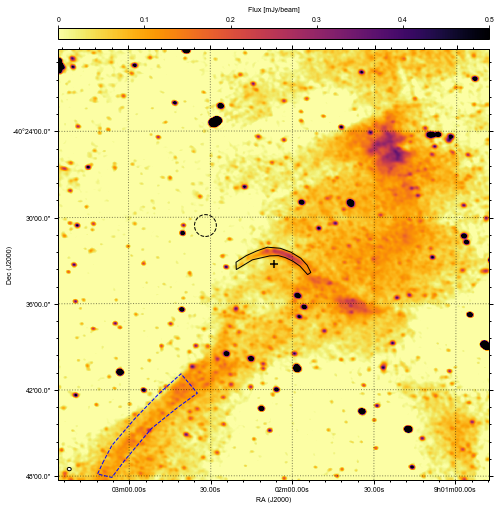

In [5]:
CM = 'inferno_r' # binary

data = "Figure1_2/VelaX-1_3MS_DDFkMS_12asec.app.restored_pbcor.fits"

fig = plt.figure(figsize=(cm2inch(double_col),cm2inch(double_col)))
plt.clf()

cg = aplpy.FITSFigure(data, figure=fig, subplot=(1,1,1))
cg.show_colorscale(cmap=CM,vmin=0.0,vmax=5e-4)

ra = 135.528588
dec = -40.554693
    
cg.recenter(ra, dec, radius=0.25)  # radius degrees => 2 deg x 2 deg

cg.show_markers(ra, dec, layer='marker_set_1', 
                edgecolor=None, facecolor='k', marker='+', s=50)

# Show the regions:
cg.show_regions('Figure1_2/bowshock_ds9_IMAGE.reg')
cg.show_regions('Figure1_2/filament_IMcoord.reg')

cg.add_beam()
cg.beam.show()
cg.beam.set_major(16.7 * u.arcsecond)
cg.beam.set_minor(13.7 * u.arcsecond)
cg.beam.set_angle(79.47 * u.degree)
cg.beam.set_corner('bottom left')
cg.beam.set_linestyle('-')
cg.beam.set_edgecolor('k')
cg.beam.set_facecolor('w')
cg.beam.set_linewidth(1)

cg.axis_labels.set_xpad(4)
cg.axis_labels.set_ypad(0)
cg.axis_labels.set_font(size=7, weight='medium',
                         stretch='normal', family='arial',
                         style='normal', variant='normal')
cg.tick_labels.set_font(size=7, weight='medium',
                         stretch='normal', family='arial',
                         style='normal', variant='normal')
cg.ticks.set_length(4)
cg.ticks.set_linewidth(1)
cg.ticks.set_color('black')

cg.frame.set_linewidth(1)  # points
cg.frame.set_color('black')

cg.add_grid()
cg.grid.show()
cg.grid.set_color('k')
cg.grid.set_linestyle(':')
cg.grid.set_linewidth(1)

ax = fig.add_subplot(111)
fakedata = np.asarray([[],[]])
plt.imshow(fakedata,aspect='auto',origin='lower',vmin=0.0,vmax=5e-4,cmap=CM,rasterized=True)

cb = plt.colorbar(orientation='horizontal', cmap=CM, shrink=1, aspect=40, pad=0, 
                  fraction=1.0,drawedges=True)

cb.set_label(r'Flux [mJy/beam]', fontsize=7, fontweight='medium', family='arial', labelpad=5)
cb.set_ticks([0., 0.0001, 0.0002, 0.0003, 0.0004, 0.0005], update_ticks=True)#0.0006, 0.0007, 0.0008, 0.0009, 0.001], update_ticks=True)
cb.set_ticklabels(['0', '0.1', '0.2', '0.3', '0.4', '0.5'])#, '0.6', '0.7', '0.8', '0.9', '1'])
cb.ax.xaxis.set_tick_params(pad=2)
cb.ax.tick_params(labelsize=7) 
cb.outline.set_linewidth(1)
cb.dividers.set_color('none')

cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

for l in cb.ax.xaxis.get_ticklabels():
    l.set_family("arial")
    
ax.axis('off')

plt.tight_layout()
plt.savefig('Figure1_2/bowshock.png', dpi=300)

## Intermezzo: the contour plot in Figure 3

Figure 3 was not created in python but using ds9. In the Figure3 folder, one can find the H$\alpha$ map from the SuperCOSMOS Survery ('ha97544.fits'), as well as the 'radio_20_50_100_200.ctr' file that contains the contours. Opening the fits file in ds9 and then loading the contours will recreate the Figure from the paper, although it does of course require correct adjustment of the colorscale. The folder also contains the figure used in the paper as pdf.

## Step 4: Plotting the radio flux density and IR/H$\alpha$ brightness profiles

The profiles of the radio flux density and the IR and H$\alpha$ brightness are measured from ds9. For this purpose, we defined three line-regions using the ds9 option Region -> Shape -> Projection. These are all approximately 2 arcminutes in length, starting at the position of Vela X-1, and angled at 0, 30, and 60 degrees West of North (i.e. 0 degrees goes through the bow shock apex). Subsequently, in the Projection window, one can select Analysis -> Plot 2D to plot the profile from the fits image. Finally, the plotted profile can be saved using File -> Save Data in the plot window. 

The saved data shows pixels as the x axis. Therefore, in order to generate Figure 4 from the paper, one needs to rescale the axis using the length of the projection region. 

The Figure4 folder contains the .reg files (3) for the three directions, the .dat files with the profiles for each band and direction (3x3=9), and the WISE W3 band IR fits image ('WISE-Band-3.fits'). The radio and H$\alpha$ images can be found in the Figure1_2 and Figure3 folders, respectively. 

#### Recreating Figure 4 from the paper

In [8]:
# Defining the length of the line projections for each direction (0, 30, 60 degrees) in arcminutes
L0 = 2.00000
L30 = 2.01195
L60 = 2.01189

In [10]:
# Reading in the profiles: Radio band, 0 degrees. Secondly, defining the x-axis, using the number
# of pixels and the previously defined length in arcminutes.
radio0 = np.genfromtxt('Figure4/radio_0deg.dat', unpack=True, usecols=[1])
radio0_x = np.linspace(L0 / len(radio0), L0, len(radio0), endpoint=True)

# Radio band, 30 degrees.
radio30 = np.genfromtxt('Figure4/radio_30deg.dat', unpack=True, usecols=[1])
radio30_x = np.linspace(L30 / len(radio30), L30, len(radio30), endpoint=True)

# Radio band, 60 degrees.
radio60 = np.genfromtxt('Figure4/radio_60deg.dat', unpack=True, usecols=[1])
radio60_x = np.linspace(L60 / len(radio60), L60, len(radio60), endpoint=True)

# Halpha band, 0 degrees.
halpha0 = np.genfromtxt('Figure4/halpha_0deg.dat', unpack=True, usecols=[1])
halpha0_x = np.linspace(L0 / len(halpha0), L0, len(halpha0), endpoint=True)

# Halpha band, 30 degrees.
halpha30 = np.genfromtxt('Figure4/halpha_30deg.dat', unpack=True, usecols=[1])
halpha30_x = np.linspace(L30 / len(halpha30), L30, len(halpha30), endpoint=True)

# Halpha band, 60 degrees.
halpha60 = np.genfromtxt('Figure4/halpha_60deg.dat', unpack=True, usecols=[1])
halpha60_x = np.linspace(L60 / len(halpha60), L60, len(halpha60), endpoint=True)

# IR band, 0 degrees.
W3_0 = np.genfromtxt('Figure4/W3_0deg.dat', unpack=True, usecols=[1])
W3_0_x = np.linspace(L0 / len(W3_0), L0, len(W3_0), endpoint=True)

# IR band, 30 degrees.
W3_30 = np.genfromtxt('Figure4/W3_30deg.dat', unpack=True, usecols=[1])
W3_30_x = np.linspace(L30 / len(W3_30), L30, len(W3_30), endpoint=True)

# IR band, 60 degrees.
W3_60 = np.genfromtxt('Figure4/W3_60deg.dat', unpack=True, usecols=[1])
W3_60_x = np.linspace(L60 / len(W3_60), L60, len(W3_60), endpoint=True)

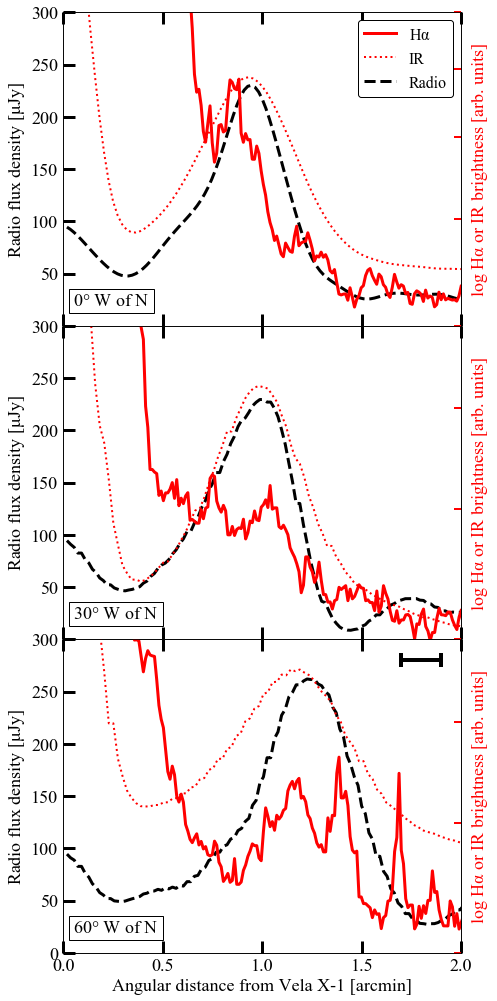

In [16]:
# Using gridspec to define the figure, to remove the vertical white space between the 3 panels. 
fig = plt.figure(figsize=(cm2inch(2*single_col),cm2inch(4*single_col)))
gs1 = gridspec.GridSpec(3, 1)
gs1.update(wspace=0.0, hspace=0.0) # removing the white space

# Defining the top panel, and twinning it to plot the IR and Halpha data with their own (log) y-axis.
ax = plt.subplot(gs1[0])
ax2 = ax.twinx() 

# Defining the axis properties
for A in [ax, ax2]:
    A.tick_params(labelsize=18, width=3, length=12, axis='both', which='major', pad=5)
    A.tick_params(labelsize=18, length=7, width=2, axis='both', which='minor', pad=5)

    A.xaxis.set_ticks_position('both')
    A.get_yaxis().set_tick_params(direction='in', which='both')
    A.get_xaxis().set_tick_params(direction='in', which='both')

# Setting axis limits and labels:
ax.set_ylim(0, 0.0003)
ax.set_ylabel(r'Radio flux density [$\mu$Jy]', fontsize=18)
ax.set_yticklabels(['', 50, 100, 150, 200, 250, 300])
ax.set_xlim(0., 2.0)
ax.set_xticklabels([])

ax2.set_yscale('log')
ax2.set_ylim(3000,7000)
ax2.set_ylabel(r'log H$\alpha$ or IR brightness [arb. units]', fontsize=18, color='red')
ax2.tick_params(axis='y', colors='red') 
ax2.tick_params(axis='y', colors='red', which='minor')
ax2.set_yticklabels([], minor=True) # Removing these ticks since the units are arbitrary

# Plotting:
ax.plot(radio0_x, radio0, 'k--', lw=3)
ax2.plot(halpha0_x, halpha0, 'r-', lw=3, label=r'H$\alpha$')
ax2.plot(W3_0_x, W3_0*9., 'r:', lw=2, label=r'IR') # Note that the factor 9 allows the IR and Halpha to be plotted on the same axis
ax2.plot([], [], 'k--', lw=3, label=r'Radio') # Empty data to make one legend, despite the two axes. 

# Writing the direction
ax.text(0.05, 20e-6, r'$0\degree$ W of N', fontsize=18, bbox=dict(facecolor='none', edgecolor='k'))

# Defining the legend.
legend = ax2.legend(loc=1, fontsize=16, ncol=1, frameon=True, framealpha=1.0)
frame = legend.get_frame()
frame.set_edgecolor('black')

####################################################################################################################
# The middle panel: when not commented, see above.
ax = plt.subplot(gs1[1])
ax2 = ax.twinx()

for A in [ax, ax2]:
    A.tick_params(labelsize=18, width=3, length=12, axis='both', which='major', pad=5)
    A.tick_params(labelsize=18, length=7, width=2, axis='both', which='minor', pad=5)

    A.xaxis.set_ticks_position('both')
    A.get_yaxis().set_tick_params(direction='in', which='both')
    A.get_xaxis().set_tick_params(direction='in', which='both')

ax.set_ylim(0, 0.0003)
ax.set_ylabel(r'Radio flux density [$\mu$Jy]', fontsize=18)
ax.set_yticklabels(['', 50, 100, 150, 200, 250, 300])
ax.set_xlim(0., 2.0)
ax.set_xticklabels([])

ax2.set_yscale('log')
ax2.set_ylim(3000,6000)
ax2.set_ylabel(r'log H$\alpha$ or IR brightness [arb. units]', fontsize=18, color='red')
ax2.tick_params(axis='y', colors='red') 
ax2.tick_params(axis='y', colors='red', which='minor')
ax2.set_yticklabels([], minor=True)

ax.plot(radio30_x, radio30, 'k--', lw=3)
ax2.plot(halpha30_x, halpha30, 'r-', lw=3)
ax2.plot(W3_30_x, W3_30*8, 'r:', lw=2) # See the top panel comments for the factor 8.

ax.text(0.05, 20e-6, r'$30\degree$ W of N', fontsize=18, bbox=dict(facecolor='none', edgecolor='k'))

####################################################################################################################
# The middle panel: when not commented, see above.
ax = plt.subplot(gs1[2])
ax2 = ax.twinx()

for A in [ax, ax2]:
    A.tick_params(labelsize=18, width=3, length=12, axis='both', which='major', pad=5)
    A.tick_params(labelsize=18, length=7, width=2, axis='both', which='minor', pad=5)

    A.xaxis.set_ticks_position('both')
    A.get_yaxis().set_tick_params(direction='in', which='both')
    A.get_xaxis().set_tick_params(direction='in', which='both')

ax.set_ylim(0, 0.0003)
ax.set_ylabel(r'Radio flux density [$\mu$Jy]', fontsize=18)
ax.set_yticklabels([0, 50, 100, 150, 200, 250, 300])
ax.set_xlim(0., 2.0)
ax.set_xlabel(r'Angular distance from Vela X-1 [arcmin]', fontsize=18) # Bottom panel: defining the x-axis label

ax2.set_yscale('log')
ax2.set_ylim(3000,6000)
ax2.set_ylabel(r'log H$\alpha$ or IR brightness [arb. units]', fontsize=18, color='red')
ax2.tick_params(axis='y', colors='red') 
ax2.tick_params(axis='y', colors='red', which='minor')
ax2.set_yticklabels([], minor=True)

ax2.plot(halpha60_x, halpha60, 'r-', lw=3)
ax.plot(radio60_x, radio60, 'k--', lw=3)
ax2.plot(W3_60_x, W3_60*10, 'r:', lw=2) # See the top panel comments for the factor 10.

# Defining the beam size marker
ax.plot([1.7, 1.9], [280e-6, 280e-6], 'k-', lw=4)
ax.plot([1.7, 1.7], [275e-6, 285e-6], 'k-', lw=4)
ax.plot([1.9, 1.9], [275e-6, 285e-6], 'k-', lw=4)

ax.text(0.05, 20e-6, r'$60\degree$ W of N', fontsize=18, bbox=dict(facecolor='none', edgecolor='k'))

####################################################################################################################
# Saving the figure.
plt.tight_layout()
plt.savefig('Figure4/ALLdeg.pdf')

## Step 5: Plotting the Chandra images with the bow shock region

#### Recreating Figure 5 from the paper

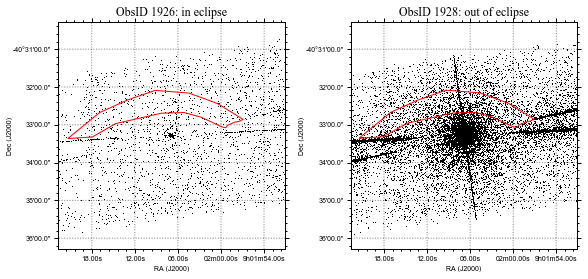

In [18]:
# Set the colormap
CM = 'binary' 

# Define the image and the size:
fig = plt.figure(figsize=(cm2inch(2*10.5),cm2inch(10.5)))
plt.clf()

################################################################################################################
# ECLIPSE DATA
################################################################################################################

# Define the .fits file with the image
data = "Figure5/acisf01926_repro_evt2.05_10keV.fits"

# Plot the map in the defined figure
cg = aplpy.FITSFigure(data, figure=fig, subplot=(1,2,1))

# Define the colormaps, min and max flux on the scale
cg.show_colorscale(cmap=CM,vmin=0.0,vmax=2e-4)

# Define the source position: centre on this. 
ra = 135.528588
dec = -40.554693
    
cg.recenter(ra, dec, radius=180*(1./3600.))  # radius in degrees; now we plot 180" in all directions, i.e. 6' by 6'

# Show the region:
cg.show_regions('Figure5/1926_bowshock_noarms_WCS.reg')

# Set the title:
cg.set_title('ObsID 1926: in eclipse')

# Set the properties of the axis labels and ticks:
cg.axis_labels.set_xpad(4)
cg.axis_labels.set_ypad(0)
cg.axis_labels.set_font(size=7, weight='medium',
                         stretch='normal', family='arial',
                         style='normal', variant='normal')
cg.tick_labels.set_font(size=7, weight='medium',
                         stretch='normal', family='arial',
                         style='normal', variant='normal')
cg.ticks.set_length(4)
cg.ticks.set_linewidth(1)
cg.ticks.set_color('black')

cg.frame.set_linewidth(1)  # points
cg.frame.set_color('black')

# Define the properties of the grid
cg.add_grid()
cg.grid.show()
cg.grid.set_color('k')
cg.grid.set_linestyle(':')
cg.grid.set_linewidth(1)

################################################################################################################
# NON ECLIPSE DATA
################################################################################################################

data = "Figure5/acisf01928_repro_evt2.05_10keV.fits"

cg = aplpy.FITSFigure(data, figure=fig, subplot=(1,2,2))

cg.show_colorscale(cmap=CM,vmin=0.0,vmax=2e-4)
    
cg.recenter(ra, dec, radius=180*(1./3600.))  

cg.show_regions('Figure5/1926_bowshock_noarms_WCS.reg')

# Set the title:

cg.set_title('ObsID 1928: out of eclipse')

# Set the properties of the axis labels and ticks:
cg.axis_labels.set_xpad(4)
cg.axis_labels.set_ypad(0)
cg.axis_labels.set_font(size=7, weight='medium',
                         stretch='normal', family='arial',
                         style='normal', variant='normal')
cg.tick_labels.set_font(size=7, weight='medium',
                         stretch='normal', family='arial',
                         style='normal', variant='normal')
cg.ticks.set_length(4)
cg.ticks.set_linewidth(1)
cg.ticks.set_color('black')

cg.frame.set_linewidth(1)  # points
cg.frame.set_color('black')

# Define the properties of the grid
cg.add_grid()
cg.grid.show()
cg.grid.set_color('k')
cg.grid.set_linestyle(':')
cg.grid.set_linewidth(1)

################################################################################################################

plt.tight_layout()
plt.savefig('Figure5/Chandra.png', dpi=250)

## Step 6: assessing the steady state of the bow shock

Here, we measure the radio R(0)/R(90), where R(theta) is defined as the distance between the bow shock and the massive star at angle theta, where theta=0 defines the bow shock apex. To measure this ratio, we measure the distance where the radio brightness profile peaks in both these directions, and assume an error of 12 arcsec (i.e. the beam size) on this angular measurement. 

In [19]:
# Reading in the profile for the 90 degree direction; the apex (0 degree) direction was already read in above.
L90 = 3.14000

radio90 = np.genfromtxt('SteadyState/radio_90deg.dat', unpack=True, usecols=[1])
radio90_x = np.linspace(L90 / len(radio90), L90, len(radio90), endpoint=True)

In [23]:
# Calculating the ratio and its error

max_0deg = radio0_x[np.argmax(radio0)]
max_90deg = radio90_x[np.argmax(radio90)]
sigma = 0.2

R = max_0deg/max_90deg
dR_squared = (1+R**2)*((sigma/max_90deg)**2.0) # Equation from error propegation
dR = dR_squared**0.5

print 'R =', np.round(R,2), '+/-', np.round(dR,2)

R = 0.5 +/- 0.12


## Step 7: defining the bow shock properties as input for the following calculations

For full details regarding the measurement of these properties, or their original from the literature, see the main paper; especially Sections 3 and 4.1.

In [25]:
# Radio measurements from the MeerKAT image

Snu = 5.27 * u.milliJansky # total bow shock radio flux
nu_obs = 1.3 * u.GHz # MeerKAT central observing frequency 

# Define the default assumed radio spectral index for the non-thermal/synchrotron scenario

alpha_thin = 0.5
p = 2.*alpha_thin+1 # electron number density index (see the main paper for the definition)

# Geometrical properties from the literature

R0 = 0.57 * u.parsec # The standoff distance taken from Gvaramadze et al. (2018)
D = 1.99e3 * u.parsec # The source distance from Kretschmar et at. (2021)

# Geometrical measurements from the MeerKAT image

DR = (35./65.)*R0 # Bow shock width, called Delta in the main paper
A_surface = 10100.0 * (u.arcsec**2.0) # the surface of the bow shock region
arcsec_to_size = (1 * u.arcsec).to(u.radian).value * D # the conversion between arcsecond to size at the distance of Vela X-1
Vbowshock = 0.28276985 * (u.pc**3.) # The bow shock volume

# printing two calculated values: the bow shock width and the volume filling fraction:
print DR
print Vbowshock / (4.*np.pi*(R0**3)/3.)

# Physical parameters from the literature

L38 = 24.3 # The stellar bolometric luminosity in units of 1e38 erg/s. From Kretschmar et al. (2021)
Rstar = 30.*cds.Rsun # The stellar radius. From Kretschmar et al. (2021)
vstar = 54.25 * u.km / u.s # The runaway velocity of the X-ray binary. From Gvaramadze et al. (2018)
Tstar = 30.9e3 * u.Kelvin # Donor star temperature. From Kretschmar et al. (2021)

Mdot = 1.0e-6 * u.Msun / u.year # Wind mass loss rate. From Grinberg et al. (2017)
vwind = 700 * u.km / u.s # Wind terminal velocity. From Grinberg et al. (2017)

a_dust = 0.2 * u.micrometer # Assumed dust grain radius. From Del Valle & Romero (2012)
Mag_IR = 5.25 # AB mag at a frequency of 4.5 micron 
lambda_IR = 4.5 * u.micrometer # IR observing frequency

0.306923076923 pc
0.364518794324


In [26]:
# Radio measurements for the overdense region, used for the comparison in the thermal scenario:
# OD stands for Overdensity; beyond that, the names are the same as defined for the bow shock above.

OD_Snu = 0.0288 * u.Jy 
OD_A_surface = 42420.2 * (u.arcsec**2.0)
OD_A_surface = ((OD_A_surface.value) * (arcsec_to_size**2.0)).to(u.pc**2)
print OD_A_surface

OD_DR = (0.0299 * u.deg).to(u.arcsec)*2.
OD_DR = (OD_DR.to(u.radian).value * D).to(u.pc)
print OD_DR

OD_Volume = OD_A_surface * OD_DR
print OD_Volume

3.94846777791 pc2
2.07697671646 pc
8.2008756404 pc3


In [27]:
# Radio measurements for the bow shock of BD +43d3654, for comparison in the thermal scenario.

# The bow shock parameters of BD +43d3654, using the results from Benaglia et al. (2010) at 4.8 GHz
BD43_D_Benaglia2010 = 1.72 * u.kpc
BD43_Snu_Benaglia2010 = 4.0 * u.mJy # brightest beam
BD43_Volume_Benaglia2010 = 0.04413*(u.pc**3) # this assumes a 12" circular beam, Delta = 2.8', and the 1.72 kpc distance.

# The bow shock parameters of BD +43d3654, using the results from Benaglia et al. (2021) at 3.0 GHz
BD43_D_Benaglia2021 = 1.72 * u.kpc
BD43_Snu_Benaglia2021 = 5.5 * u.mJy # brightest beam

# Calculating the beam volume for the elliptical beam:
a_Benaglia2021 = 20.2 * u.arcsec
b_Benaglia2021 = 12.5 * u.arcsec
a_Benaglia2021_phys = (a_Benaglia2021.to(u.radian).value*BD43_D_Benaglia2021).to(u.pc)
b_Benaglia2021_phys = (b_Benaglia2021.to(u.radian).value*BD43_D_Benaglia2021).to(u.pc)
area_Benaglia2021 = np.pi*a_Benaglia2021_phys*b_Benaglia2021_phys

Delta_Benaglia2021 = ((2.8 * u.arcmin).to(u.radian).value)*BD43_D_Benaglia2021

BD43_Volume_Benaglia2021 = (area_Benaglia2021*Delta_Benaglia2021).to(u.pc**3)

In [28]:
# Physical constants

E_elec = 10**np.linspace(6, 14, 1000, endpoint=True) * u.eV # the range of non-thermal electron energies used for plotting

sigma_T = 6.6524e-25 * u.cm * u.cm # Thompson cross-section
sigma_SB = 5.67037442e-8 * u.Watt / (u.m**2.0) / (u.Kelvin**4.0) # Stefan-Boltzmann constant
    
c = 2.998e10 * u.cm / u.s # Speed of light
m_e = 9.10938e-31 * u.kg # electron mass
mu0 = cds.mu0 # Permeability of free space

planck = 6.6260701e-34 * u.Joule * u.s # Planck constant
red_planck = planck / (2*np.pi) # Reduced Planck constant
hred_c = (red_planck * c).to(u.Joule * u.m) # Reduced Planck constant times the speed of light in convenient units 

r0 = 2.8179403e-13 * u.cm # The classical electron radius
alpha = 0.0072973526 # The fine structure constant

Rayleigh = 5.66e-18 * u.erg * (u.s**-1) * (u.cm**-2) * (u.arcsec**-2) # 1 Rayleigh

In [29]:
# Assumptions made in the thermal and non-thermal calculation. See main paper for details

Z = 1.0 # The assumed charge of the wind material
xi = 1.0 # Assuming Bohn diffusion in the Diffusive Shock Acceleration

a = 1. # Assumed ratio of protons to electrons 
eta = 1.0 + a

## Step 8: the thermal/free-free scenario

The reasoning is as follows: in this scenario, the shock causes an enhancement of the ISM density and change of the temperature, leading to free-free emission. This is then observed in both the radio band and in H$\alpha$. 

To consider the feasibility of this scenario, let's consider Longair (2011). The radio emissivity is given by:

$$\kappa_\nu = 6.8\times10^{-38} \text{ erg cm}^{-3}\text{ s}^{-1}\text{ Hz}^{-1} Z^2 T^{-1/2} n n_e g(\nu, T) e^{\frac{-h\nu}{kT}}$$

Note that the normalisation of this equation comes from Gallo et al. (2005), and assumes temperatures in Kelvin and number densities in cm$^{-3}$. This is therefore different from Longair, which assumes m$^{-3}$ and uses Joules instead of ergs. However, the Longair equation makes fewer a priori assumptions than Gallo et al. (2005), so that we can introduce those explicitly here:
* We assume that $Z=1$
* We assume that $n = n_e$
* We use that at $\nu = 1.3$ GHz, we can ignore the exponent: $h\nu/k \approx 6.2\times10^{-2}$ K, so when we look at any temperature $T>1$ K, the exponent would be $\leq -10^{-2}$. In other words, the entire factor approaches unity.

In the equation above, $g(\nu, T)$ is the gaunt factor. In the radio band, Longair (2011) poses:

$$ g(\nu, T) \approx \frac{\sqrt{3}}{2\pi} \left[\ln\left(\frac{128\epsilon_0^2 k^3 T^3}{m_e e^4 \nu^2 Z^2}\right) - \gamma^2\right]$$

where $\gamma \approx 0.577...$ equals Euler's constant.

At very low frequencies, this emission is absorbed. However, as argued in the main paper, we ignore that at radio frequencies and we can link the above emissivity to the observed flux density via:

$$\kappa_\nu = \frac{4\pi D^2 S_\nu}{V_{\rm bowshock}}$$

Combining these equations, we find that the observed radio flux density sets a relation between the electron number density and temperature.

We can find a similar relation by considering the H$\alpha$ surface brightness. For this, we can use the equation in Gvaramadze et al. (2018):

$$j_{\rm H\alpha} = 2.85\times10^{-33}\text{erg s}^{-1}\text{ cm}^{-3}\text{ arcsec}^{-2} \left( \frac{T}{\text{K}} \right)^{-0.9}\left(\frac{n_e}{\text{cm}^{-3}}\right)^2$$

The temperature and $n_e$ depend on position, but in our analysis, we have assumed they are uniform with depth. So then, we find that the surface brightness is given by:

$$S_{\rm H\alpha} = \int j_{\rm H\alpha}(x) dx = j_{\rm H\alpha} \Delta$$

In other words, we find a simple monotonic relation between electron number density and temperature from the H$\alpha$ maps:

$$n_e(T) = \sqrt{S_{\rm H\alpha}\frac{(T/\text{K})^{0.9}}{C_{\rm H\alpha}\Delta}} \text{ cm}^{-3}$$ 

where $C_{\rm H\alpha} = 2.85\times10^{-33}\text{erg s}^{-1}\text{ cm}^{-3}\text{ arcsec}^{-2}$.

#### Let us plot both relations, using both the Kaper et al. (1997) and the Gvaramadze et al. (2018) H$\alpha$ maps.

In [32]:
def gaunt(nu, T, z):
    # The Gaunt factor
        
    F1 = 128.*(cds.eps0**2)*(cds.k**3)*(T**3)
    F2 = m_e * (cds.e**4)*(nu**2)*(z**2)
    
    G = (3**0.5 / (2.*np.pi)) * (np.log(F1/F2) - 0.5772156649)
    
    return G

In [33]:
# Defining a temperature axis between 1e1 and 1e8 K
T_axis = 10**np.linspace(1, 8, 1000, endpoint=True) * u.Kelvin

#### The H$\alpha$ calculation:

In [34]:
# Defining the measured Halpha surface brightnesses, and calculating the resulting electron density 
# as a function of temperature

# The constant (see above)
C_Ha = 2.85e-33 * u.erg * (u.s**-1) * (u.cm**-3) * (u.arcsec**-2)

### Calculation for Gvaramadze et al. (2018), assuming a ~10% uncertainty on the surface brightness
S_Ha_G18 = 43. * Rayleigh
dS_Ha_G18 = 5. * Rayleigh

# Calculating the electron number density
Ha_n_e_G18 = (((S_Ha_G18/C_Ha) * (T_axis.value**0.9) / DR)**0.5).to(u.dimensionless_unscaled)
Ha_n_e_G18 = Ha_n_e_G18 * u.cm**-3

# Calculating the electron number density uncertainty
sigma_Ha_n_e_G18 = 0.5 * Ha_n_e_G18 * (dS_Ha_G18 / S_Ha_G18) # Equation from error propegation

### Calculation for Kaper et al. (1997): the surface brightness lies within a factor 2 of 1e-16 erg/s/cm^2/arcsec^2 
S_Kaper_min = (5e-16 * u.erg * (u.s**-1) * (u.cm**-2) * (u.arcsec**-2) / Rayleigh).to(u.dimensionless_unscaled)
S_Kaper_max = (2e-15 * u.erg * (u.s**-1) * (u.cm**-2) * (u.arcsec**-2) / Rayleigh).to(u.dimensionless_unscaled)

S_Ha_K = Rayleigh * (S_Kaper_max + S_Kaper_min)/2.
dS_Ha_K = Rayleigh * (S_Kaper_max - S_Kaper_min)/2.

# Calculating the electron number density
Ha_n_e_K = (((S_Ha_K/C_Ha) * (T_axis.value**0.9) / DR)**0.5).to(u.dimensionless_unscaled)
Ha_n_e_K = Ha_n_e_K * u.cm**-3

# Calculating the electron number density uncertainty
sigma_Ha_n_e_K = 0.5 * Ha_n_e_K * (dS_Ha_K / S_Ha_K) # Equation from error propegation

#### The radio calculation for the bow shock:

In [35]:
C_radio = 6.8e-38 * u.erg * u.cm**-3 * u.s**-1 * u.Hz**-1

kappa_nu = (4.*np.pi*(D**2)*Snu) / Vbowshock
n_e_squared = kappa_nu / (C_radio * (T_axis.value**-0.5) * gaunt(nu_obs, T_axis, Z))

# The electron number density:
n_e = (n_e_squared**0.5).to(u.dimensionless_unscaled) # units: cm^-3.

# The electron number density uncertainty, from error propegation:
sigma_n_e = 0.5 * n_e * (0.07 * u.mJy / Snu) 

#### The radio calculation for the overdense region (where we don't have the Halpha measurements)

In [36]:
OD_kappa_nu = (4*np.pi*(D**2)*OD_Snu) / OD_Volume

OD_n_e_squared = OD_kappa_nu / (C_radio * (T_axis.value**-0.5) * gaunt(nu_obs, T_axis, Z))
OD_n_e = ((OD_n_e_squared**0.5).to(u.dimensionless_unscaled)) * (u.cm**-3)

#### Recreating Figure 6 from the paper

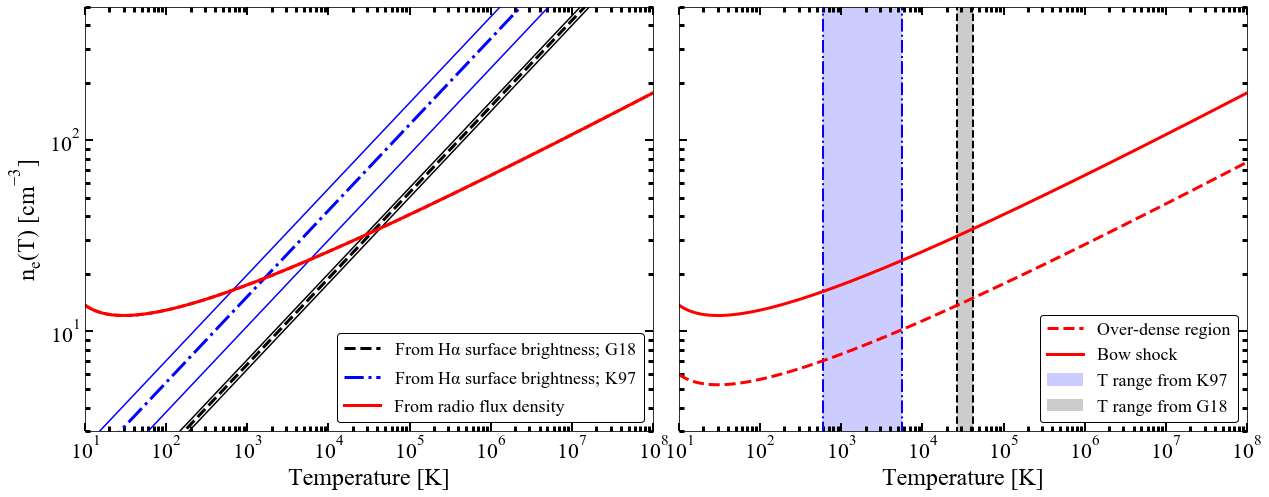

In [46]:
fig = plt.figure(figsize=(cm2inch(5*single_col),cm2inch(2*single_col)))

ax = fig.add_subplot(121)

ax.tick_params(labelsize=LS, width=2, length=8, axis='both', which='major', pad=5)
ax.tick_params(labelsize=LS, length=5, width=3, axis='both', which='minor', pad=5)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

ax.plot(T_axis, Ha_n_e_G18, 'k--', lw=3, label=r'From H$\alpha$ surface brightness; G18')
ax.plot(T_axis, Ha_n_e_G18-sigma_Ha_n_e_G18, 'k-', lw=1.5)
ax.plot(T_axis, Ha_n_e_G18+sigma_Ha_n_e_G18, 'k-', lw=1.5)

ax.plot(T_axis, Ha_n_e_K, 'b-.', lw=3, label=r'From H$\alpha$ surface brightness; K97')
ax.plot(T_axis, Ha_n_e_K-sigma_Ha_n_e_K, 'b-', lw=1.5)
ax.plot(T_axis, Ha_n_e_K+sigma_Ha_n_e_K, 'b-', lw=1.5)

ax.plot(T_axis, n_e, 'r-', lw=3, label='From radio flux density')
ax.plot(T_axis, n_e + sigma_n_e, 'r--', lw=2)
ax.plot(T_axis, n_e - sigma_n_e, 'r--', lw=2)

ax.set_xlim(10, 1e8)
ax.set_ylim(3., 5e2)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'Temperature [K]', fontsize=FS+2)
ax.set_ylabel(r'$n_e(T)$ [cm$^{-3}$]', fontsize=FS+2)

legend = ax.legend(loc=4, fontsize=FS-4, ncol=1, frameon=True, framealpha=1.0)
frame = legend.get_frame()
frame.set_edgecolor('black')

ax = fig.add_subplot(122)

ax.tick_params(labelsize=LS, width=2, length=8, axis='both', which='major', pad=5)
ax.tick_params(labelsize=LS, length=5, width=3, axis='both', which='minor', pad=5)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

ax.plot([5600, 5600], [1e-1, 1e100], 'b-.', lw=2)
ax.plot([600, 600], [1e-1, 1e100], 'b-.', lw=2)
ax.fill_between([600,5600], [1e-1,1e-1], [1e100,1e100], facecolor='b', alpha=0.2, label='T range from K97')

ax.plot([26694, 26694], [1e-1, 1e100], 'k--', lw=2)
ax.plot([41939, 41939], [1e-1, 1e100], 'k--', lw=2)
ax.fill_between([26694,41939], [1e-1,1e-1], [1e100,1e100], facecolor='0.80', label='T range from G18')

ax.plot(T_axis, OD_n_e, 'r--', lw=3, label='Over-dense region')
ax.plot(T_axis, n_e, 'r-', lw=3, label='Bow shock')

ax.set_xlim(10, 1e8)
ax.set_ylim(3., 5e2)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'Temperature [K]', fontsize=FS+2)
ax.set_yticklabels([])

legend = ax.legend(loc=4, fontsize=FS-4, ncol=1, frameon=True, framealpha=1.0)
frame = legend.get_frame()
frame.set_edgecolor('black')

plt.tight_layout()
plt.savefig('ThermalScenario/ne_twopanels.pdf')

#### The radio calculation for the bow shock of BD +43$^{\rm o}$3654, using the Benaglia et al. (2010,2021) measurements

In [47]:
# The calculation using the values from Benaglia et al. (2010) at 4.8 GHz
BD43_kappa_nu_Benaglia2010 = 4*np.pi*(BD43_D_Benaglia2010**2)*BD43_Snu_Benaglia2010 / BD43_Volume_Benaglia2010

BD43_n_e_squared_Benaglia2010 = BD43_kappa_nu_Benaglia2010 / (C_radio * (T_axis.value**-0.5) * gaunt(4.8*u.GHz, T_axis, Z))
BD43_n_e_Benaglia2010 = ((BD43_n_e_squared_Benaglia2010**0.5).to(u.dimensionless_unscaled)) * (u.cm**-3)

# The calculation using the values from Benaglia et al. (2021) at 3 GHz
BD43_kappa_nu_Benaglia2021 = 4*np.pi*(BD43_D_Benaglia2021**2)*BD43_Snu_Benaglia2021 / BD43_Volume_Benaglia2021

BD43_n_e_squared_Benaglia2021 = BD43_kappa_nu_Benaglia2021 / (C_radio * (T_axis.value**-0.5) * gaunt(3.0*u.GHz, T_axis, Z))
BD43_n_e_Benaglia2021 = ((BD43_n_e_squared_Benaglia2021**0.5).to(u.dimensionless_unscaled)) * (u.cm**-3)

#### Recreating Figure 7 from the paper:

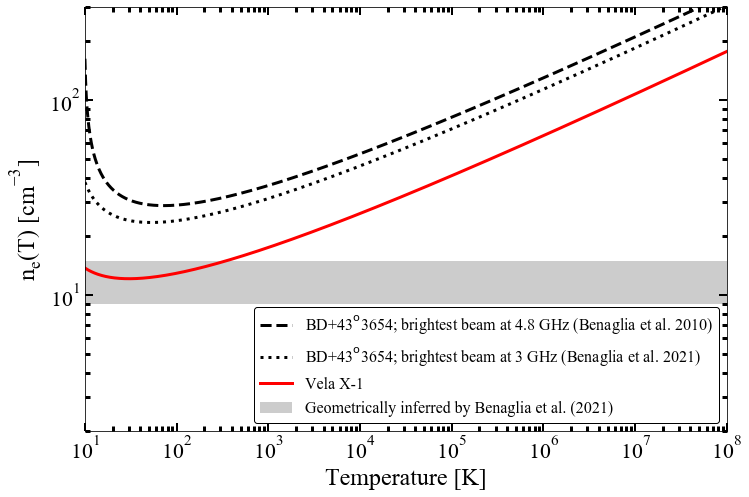

In [48]:
fig = plt.figure(figsize=(cm2inch(3*single_col),cm2inch(2*single_col)))
ax = fig.add_subplot(111)

ax.tick_params(labelsize=LS, width=2, length=8, axis='both', which='major', pad=5)
ax.tick_params(labelsize=LS, length=5, width=3, axis='both', which='minor', pad=5)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

ax.plot(T_axis, BD43_n_e_Benaglia2010, 'k--', lw=3, label=r'BD+43$^{\rm o}$3654; brightest beam at 4.8 GHz (Benaglia et al. 2010)')
ax.plot(T_axis, BD43_n_e_Benaglia2021, 'k:', lw=3, label=r'BD+43$^{\rm o}$3654; brightest beam at 3 GHz (Benaglia et al. 2021)')
ax.plot(T_axis, n_e, 'r-', lw=3, label='Vela X-1')

ax.fill_between([1e-1, 1e100], [9., 9.], [15., 15.], facecolor='0.8', label='Geometrically inferred by Benaglia et al. (2021)')

ax.set_xlim(10, 1e8)
ax.set_ylim(2., 3e2)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'Temperature [K]', fontsize=FS+2)
ax.set_ylabel(r'$n_e(T)$ [cm$^{-3}$]', fontsize=FS+2)

legend = ax.legend(loc=4, fontsize=FS-6, ncol=1, frameon=True, framealpha=1.0)
frame = legend.get_frame()
frame.set_edgecolor('black')

plt.tight_layout()
plt.savefig('ThermalScenario/ne_withotherBS.pdf')

#### Final step: calculating the optical depth for free-free emission to confirm that the emission is optically thin:

The optical depth is given by

$$\tau_\nu = \int \chi_\nu dx \approx \chi_\nu \Delta = \frac{\kappa_\nu c^2}{8\pi h \nu^3}\left(e^{h\nu/kT} - 1\right)\Delta$$

We can assume a typical electron density around $10$ cm$^{-3}$ and a temperature of $10^4$ K and find:

In [49]:
kappa_nu_tau = C_radio * ((1e4)**(-0.5)) * gaunt(T=1e4 * u.K, nu=nu_obs, z=1) * (10**2)
chi = kappa_nu_tau * (c**2) * (np.e**(planck * nu_obs / (cds.k * 1e4 * u.K)) - 1) / (8.*np.pi*planck*(nu_obs**3))
print chi.to(u.pc**-1)
tau = chi * DR
print tau.to(u.dimensionless_unscaled)

2.07497154033e-05 1 / pc
6.36856649687e-06


## Step 9: the non-thermal/synchrotron scenario

Now, we can turn to the non-thermal calculations from Section 4.3 of the main paper, following the structure of that Section. The calculations below will jump between main text and appendix, introducing appendix calculations wherever those are referred to in the main text. 

#### The equipartition calculation

We can start by evaluating what the magnetic field and particle/magnetic energy in the system are, if we assume equipartition. For this purpose, as explained in the paper, we will assume that the electron number density follows a power law distribution as a function of energy,

$$N(E) = \kappa E^{-p}$$

between a minimum and maximum energy $E_{\rm min}$ and $E_{\rm max}$. The power law index is then related to the radio spectral index via $p=2\alpha+1$, with $S_\nu \propto \nu^{-\alpha}$. In this first calculation, we assume that $\alpha=0.5$, and set the minimum and maximum energies to $511$ and $3\times10^9$ keV. 

We also define the ratio between protons and electrons to be equal to $a$, and assume that $a=1$. Therefore the total energy in particles is $\epsilon_{\rm particles} = (1+a)\epsilon_{\rm electrons} \equiv \eta \epsilon_{\rm electrons}$. The total energy in the electrons is simply the weighted mean of the electron number density multiplied by the bow shock volume $V_{\rm bowshock}$:

$$W_{\rm electrons} = V_{\rm bowshock} \times \epsilon_{\rm electrons} = V_{\rm bowshock} \int_{E_{\rm min}}^{E_{\rm max}}\kappa E^{1-p} dE$$

The normalisation $\kappa$ is constrained by the radio flux, for a given magnetic field and spectral shape: 

$$J_{\nu} = \frac{\sqrt{3}e^3 B \kappa}{4\pi\epsilon_0 c m_e} \left(\frac{3eB}{2\pi\nu m_e^3 c^4}\right)^{(p-1)/2} a(p)$$

where the factor $a(p)$ is defined as

$$a(p) = \frac{\sqrt{\pi}}{2} \frac{\Gamma\left(\frac{p}{4} + \frac{19}{12} \right) \Gamma\left(\frac{p}{4} - \frac{1}{12} \right) \Gamma\left(\frac{p}{4} + \frac{5}{4} \right)}{(p+1) \Gamma\left(\frac{p}{4} + \frac{7}{4} \right)}$$ 

and $\Gamma(x)$ is the Gamma-function. As a final ingredient, the observed radio flux is related to $J_{\nu}$ via $J_{\nu} = 4\pi D^2 S_{\nu} / V_{\rm bowshock}$. Combining these equations into an expression for the total particle energy yields:

$$W_{\rm par} = 4\pi D^2 S_{\nu} \eta \frac{4\pi\epsilon_0 c m_e}{\sqrt{3}e^3 B a(p)} \left(\frac{3eB}{2\pi\nu m_e^3 c^4}\right)^{-\frac{p-1}{2}} \int_{E_{\rm min}}^{E_{\rm max}} E^{1-p} dE$$

The energy in the magnetic field is, on the other hand, given by 

$$W_{\rm mag} = V_{\rm bowshock}\frac{B^2}{8\pi}$$

Below, we plot these two energies and their sum as a function of the magnetic field, mimimize the total energy, and find the corresponding magnetic field, and particle and magnetic energies.

In [50]:
# Defining the function a(p)
def a_p(p):
    
    F1 = (np.pi**0.5)/(2.*(p+1.))
    F2 = scipy.special.gamma(p/4. + 19./12.)
    F3 = scipy.special.gamma(p/4. - 1./12.)
    F4 = scipy.special.gamma(p/4. + 5./4.)
    F5 = scipy.special.gamma(p/4. + 7./4.)
    
    return F1*F2*F3*F4/F5

In [51]:
# Defining the minimum and maximum electron energies, and the energy axes E and dE used for numerical integration
E_min = 5.11e5 * u.eV
E_max = 3e12 * u.eV
E_integral_axis = 10**np.linspace(np.log10(E_min.value), np.log10(E_max.value), 1001, endpoint=True) * u.eV
dE_integral_axis = E_integral_axis[1:] - E_integral_axis[:-1]
E_integral_axis = E_integral_axis[:-1]
# Note that with these definitions, the integral is approached numerically as a sum over i of f(E_i) * dE_i

In [52]:
# Defining the magnetic field axis
B_axis = 10**np.linspace(0, 5, 100000, endpoint=True) * u.microGauss

# Calculating the magnetic energy as a function of the magnetic field strength
W_mag_vs_B = (Vbowshock * (B_axis**2) / (2*cds.mu0)).to(u.erg)

# Calculating the electron energy as a function of the magnetic field strength, in three steps due to the long equation:
W_part_vs_B = 4*np.pi*(D**2)*Snu*eta*4*np.pi*cds.eps0*c*m_e/((3.**0.5)*(cds.e**3.)*B_axis*a_p(p))
W_part_vs_B = W_part_vs_B * ((3*cds.e*B_axis/(2*np.pi*nu_obs*(m_e**3)*(c**4)))**(-1.*(p-1.)/2.))
W_part_vs_B = W_part_vs_B * sum(dE_integral_axis*(E_integral_axis**(1.-p)))

In [53]:
# Finding the minimum (by finding the maximum of 1 over the total energy)
B_equipartition = B_axis[np.argmax(1./(W_part_vs_B.to(u.erg)+W_mag_vs_B.to(u.erg)).value)]
B_equipartition

<Quantity 29.89611505 uG>

#### Recreating Figure A1 from the Appendix

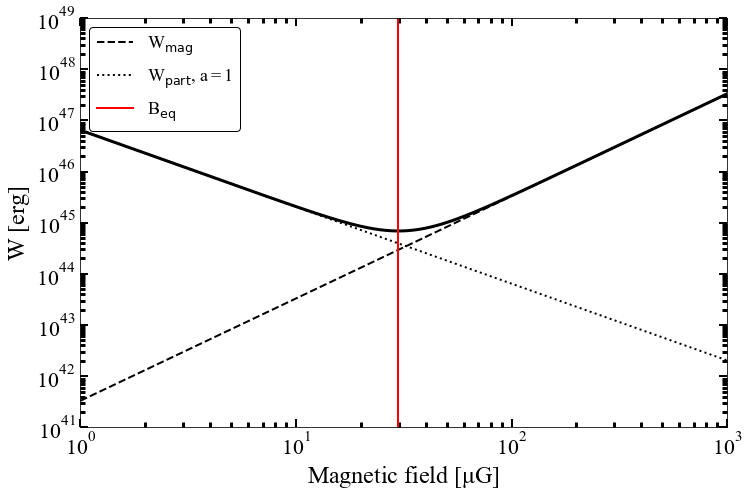

In [54]:
# Plotting the electron and magnetic energy, and their sum, versus magnetic field
fig = plt.figure(figsize=(cm2inch(3*single_col),cm2inch(2*single_col)))
ax = fig.add_subplot(111)

ax.tick_params(labelsize=LS, width=2, length=8, axis='both', which='major', pad=5)
ax.tick_params(labelsize=LS, length=5, width=3, axis='both', which='minor', pad=5)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

ax.plot(B_axis, W_mag_vs_B.to(u.erg), 'k--', lw=2, label=r'$W_{\rm mag}$')
ax.plot(B_axis, W_part_vs_B.to(u.erg), 'k:', lw=2, label=r'$W_{\rm part}$, $a = 1$')
ax.plot(B_axis, W_part_vs_B.to(u.erg)+W_mag_vs_B.to(u.erg), 'k-', lw=3)

ax.plot([B_equipartition.value,B_equipartition.value], [1, 1e100], 'r-', lw=2, label=r'$B_{\rm eq}$')

ax.set_xlim(1e0, 1e3)
ax.set_ylim(1e41, 1e49)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('Magnetic field [$\mu$G]', fontsize=FS+2)
ax.set_ylabel(r'$W$ [erg]', fontsize=FS+2)

legend = ax.legend(loc=2, fontsize=FS-4, ncol=1, frameon=True, framealpha=1.0)
frame = legend.get_frame()
frame.set_edgecolor('black')

plt.tight_layout()
plt.savefig('NonThermalScenario/B_eq'+str(p)+'.pdf')

In [60]:
# Calculating the corresponding energies in the magnetic field and particle population:
# Note: this repeats the above calculation, but now for only the equipartition magnetic field.

# The magnetic field: 
W_mag_vs_B = (Vbowshock * (B_equipartition**2) / (2*cds.mu0)).to(u.erg)
print 'Wmag:', W_mag_vs_B.to(u.erg)

# The particles:
W_part = 4*np.pi*(D**2)*Snu*eta*4*np.pi*cds.eps0*c*m_e/((3.**0.5)*(cds.e**3.)*B_equipartition*a_p(p))
W_part = W_part * ((3*cds.e*B_equipartition/(2*np.pi*nu_obs*(m_e**3)*(c**4)))**(-1.*(p-1.)/2.))
W_part = W_part * sum(dE_integral_axis*(E_integral_axis**(1.-p)))
print 'Wpar:', W_part.to(u.erg)

Wmag: 2.95443466081e+44 erg
Wpar: 3.94002388568e+44 erg


#### The wind kinetic power and equipartition time scale

Next, we can turn to comparing these energies to the available kinetic power in the stellar wind. The kinetic power passing through the bow shock is given by

$$L_{\rm wind} = \frac{\eta_{\rm vol} \dot{M}_{\rm wind}  v^2_{\infty}}{2}$$

We can then define a equipartition time scale, that estimates on what time scale the wind can power the particle population:

$$\tau_{\rm eq} \equiv W_{\rm par}/L_{\rm wind}$$

In [68]:
# Calculating the volume fraction:
eta_volume = Vbowshock / (4.*np.pi*(R0**3)/3.)
print 'eta_vol =', eta_volume

# Calculating the available kinetic wind power:
Lwind = eta_volume*(0.5*(Mdot)*(vwind**2)).to(u.erg/u.s)
print 'L_wind =', Lwind

# Finally, calculating the equipartition time scale:
t_equipartition = (W_part / Lwind).to(u.s)
print 't_eq =', t_equipartition, '=', t_equipartition.to(u.yr)

eta_vol = 0.364518794324
L_wind = 5.62732850188e+34 erg / s
t_eq = 7001588559.06 s = 221.866953097 yr


#### The stellar magnetic field

We can also estimate the stellar magnetic field $B_{*}$ from the equipartition magnetic field, via 

$$B_{*}\approx~2.5B_{\rm eq} (R_0/R_{*})$$

where $R_0$ is the standoff distance and $R_*$ is the stellar radius. 

In [70]:
(B_equipartition * (R0/Rstar) * 2.5).to(u.G)

<Quantity 62.98496721 G>

#### Estimating the relevant acceleration, cooling, and escape time scales

Here, we will follow the description in the paper to calculate the time scales of diffusive shock acceleration of the electrons, as well as their radiative cooling via inverse Compton processes, synchrotron emission, and relativistic Brehmsstrahlung, and their diffusive escale. We will calculate and plot these time scales as a function of electron energy, to assess i) the maximum electron energy and ii) the dominant energy loss process.

For this calculation, we will assume the equipartition magnetic field

Let's start with synchrotron cooling:

$$t_{\rm sync}^{-1} = \frac{4}{3}\frac{\sigma_{\rm T} c W_{\rm mag}}{m_e c^2} \left(\frac{E}{m_e c^2}\right)$$

In [76]:
Umag = ((B_equipartition**2)/(2*mu0))

t_sync_inverse = (4./3.)*((sigma_T*c*Umag)/(m_e*c*c))*(E_elec / (m_e*c*c))
t_sync = (1./t_sync_inverse).to(u.s)

Now we can turn to the inverse Compton cooling: electrons can cool from up-scattering either IR or stellar photons.

Let's start with the IR photons: first, we can calculate the expected dust temperature based on the properties of the donor star, using

$$T_{\rm dust} \approx 27 \left(\frac{a_{\rm dust}}{\mu\text{m}}\right)^{-1/6} \left(\frac{L_{*}}{10^{38} \text{ erg/s}}\right)^{1/6} \left(\frac{R_0}{\text{pc}}\right)^{-1/3} \text{ K}$$

In [85]:
Tdust = (27.0 * u.Kelvin) * ((a_dust / u.micrometer)**(-1./6.)) * (L38**(1./6.)) * ((R0 / u.parsec)**(-1./3.)) 
print 'T_dust =', Tdust

T_dust = 72.4716571226 K


However, this temperature is not necessarily consistent with the observed IR magnitude of the bow shock. We can correct for that using the the grey body correction:

$$\kappa_{\rm dust} = \frac{L_{\rm IR}}{A\sigma_{\rm SB}T_{\rm dust}^4}$$

where we can calculate the IR luminosity $L_{\rm IR}$ from

$$F_{\rm IR} = 10^{23 - (\text{IR}_{\rm mag} + 48.6)/2.5} \text{ Jy}$$
$$L_{\rm IR} = 4 \pi D^2 F_{\rm IR} c / \lambda_{\rm IR}$$

This way, we can correct for the fact that the IR emission is not completely optically thick.

In [79]:
# Calculate the luminosity in IR:
F_IR = 10.**(23. - (Mag_IR + 48.6)/2.5) * u.Jansky
nu_IR = (c / lambda_IR).to(u.Hz)
L_IR_radiative = 4.*np.pi*(D**2.0)*F_IR*nu_IR
L_IR_radiative = L_IR_radiative.to(u.erg / u.s)
print 'L_IR =', L_IR_radiative

# Calculate the Grey body correction from Khangulyan et al. 2014 (see also Del Palacio et al. 2018) for the dust
dust_surface = (A_surface.value) * (arcsec_to_size**2.0)
kappa_dust = L_IR_radiative / ((dust_surface * sigma_SB * (Tdust**4.0)).to(u.erg / u.s))
print 'kappa_dust =', kappa_dust

L_IR = 9.10408328459e+36 erg / s
kappa_dust = 0.000650239528373


We can then calculate the cooling time scales in the Thompson and the Klein-Nishina regime, using $\overline{E} = E/m_e c^2$ and $\overline{T}_{\rm dust} \equiv kT_{\rm dust}/m_e c^2$, via

$$\left(t_{\rm IC,dust}^{\rm Thompson}\right)^{-1} = \frac{4c\overline{E}}{9}\frac{\pi^2 \kappa_{\rm dust} \overline{T}_{\rm dust}^4 m_e^3 c^3 8\pi r_0^2}{15 \hbar^3}$$

and $$t_{\rm IC,dust}^{\rm KN} = \left(5\times10^{-17}\text{ sec}\right)\times \overline{T}_{\rm dust}^{-2.3} \overline{E}^{0.7} \kappa_{\rm dust}^{-1}$$

Finally, these two are summed.


In [80]:
# Scaling E and T:
E_elec_scaled = E_elec / ((m_e*c*c).to(u.eV))
Tdust_scaled = ((cds.k * Tdust).to(u.eV)) / ((m_e*c*c).to(u.eV))

In [81]:
# The Thompson regime:
t_IC_inverse_Thompson = (4.0*c*E_elec_scaled / 9.0)*(np.pi*np.pi*kappa_dust*(Tdust_scaled**4.0)*(m_e**3.0)*(c**3.0))*(8*np.pi*r0*r0) / (15*(red_planck**3.0))
t_IC_dust_Thompson = (1. / t_IC_inverse_Thompson).to(u.s)

In [82]:
# The KN regime:
t_IC_dust_KNlimit = (5e-17 * u.s) * (Tdust_scaled**-2.3) * (E_elec_scaled**0.7) / kappa_dust

In [83]:
# The total cooling time scale:
t_IC_dust = t_IC_dust_Thompson + t_IC_dust_KNlimit

Then, we can turn to the upscattering of stellar photons. For this purpose, we make two changes: firstly, in the Thompson and KN-regime equations above, the dust temperature is replaced by the stellar temperature. Secondly, the correction factor is now calculated as:

$$\kappa_* = (R_*/2R_0)^2$$

In [84]:
kappa_star = (Rstar.to(u.parsec) / (2.*R0))**2.0
print 'kappa_star =', kappa_star

kappa_star = 3.52026796127e-13


In [86]:
# Using the new correction factor, and scaling the stellar temperature, we can repeat the above calculations:
Tstar_scaled = ((cds.k * Tstar).to(u.eV)) / ((m_e*c*c).to(u.eV))

t_IC_inverse_Thompson = (4.0*c*E_elec_scaled / 9.0)*(np.pi*np.pi*kappa_star*(Tstar_scaled**4.0)*(m_e**3.0)*(c**3.0))*(8*np.pi*r0*r0) / (15*(red_planck**3.0))
t_IC_star_Thompson = (1. / t_IC_inverse_Thompson).to(u.s)

t_IC_star_KNlimit = (5e-17 * u.s) * (Tstar_scaled**-2.3) * (E_elec_scaled**0.7) / kappa_star

t_IC_star = t_IC_star_Thompson + t_IC_star_KNlimit

Then, we can turn to Relativistic brehmsstrahlung. Here, we will use that

$$t^{-1}_{\rm Br} = 4nZ^2r_e^2\alpha c\left[\ln \frac{2E}{m_e c^2} - \frac{1}{3}\right]$$

We will also assume that the density $n$ equals $4$ times the wind number density in the shock, where the wind density is given by 

$$n_w = \frac{\dot{M}}{4\pi R_0^2 v_{\rm wind}m_p}$$



In [87]:
wind_density = (Mdot / (4*np.pi*(R0**2.0)*vwind)).to(u.kg * u.m**-3.0)
wind_number_density = (wind_density / u.M_p).to(u.m**-3.0)

t_brehms_inverse = 4*4*wind_number_density*(Z**2.0)*(r0**2.0)*alpha*c*np.log(2.0*E_elec / (u.M_e * c * c) - 1./3.)

t_brehms = (1./t_brehms_inverse).to(u.s)

Having calculated all cooling time scales, we can end with acceleration and escape. We calculate the time scale of electron acceleration following 

$$t_{\rm acc} = \frac{20}{3} \xi \frac{E_{\rm electron}}{eB} \left( \frac{1}{v_{\rm wind}} \right)^2$$

while we calculate the escape time scale from diffusion as

$$t_{\rm esc} = \frac{\Delta}{v_{\rm wind}}$$

In [91]:
t_acc = ((20./3.)*xi*E_elec / (cds.e * B_equipartition * (vwind**2.0))).to(u.s)

In [93]:
t_conv = (DR / vwind).to(u.s) 

#### Recreating Figure 8 from the paper:

To recreate Figure 8, we plot these time scales as function of electron energy, also including the equipartition time scale.

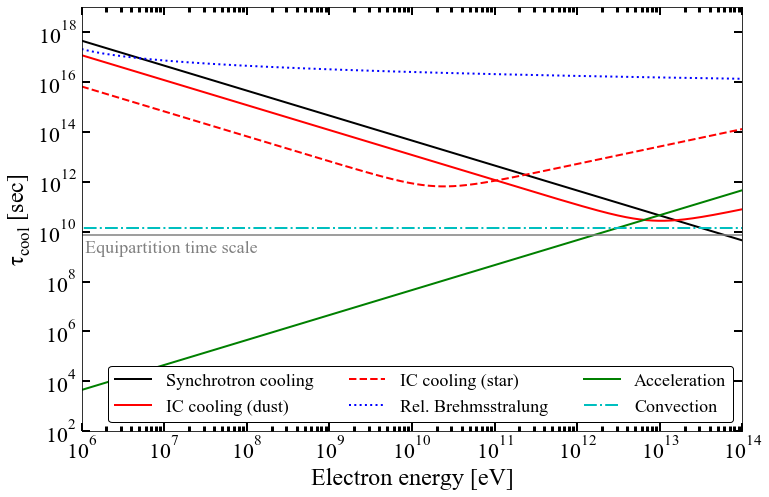

In [94]:
fig = plt.figure(figsize=(cm2inch(3*single_col),cm2inch(2*single_col)))
ax = fig.add_subplot(111)

ax.tick_params(labelsize=LS, width=2, length=8, axis='both', which='major', pad=5)
ax.tick_params(labelsize=LS, length=5, width=3, axis='both', which='minor', pad=5)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

ax.plot(E_elec, t_sync, 'k-', lw=2, label='Synchrotron cooling')
ax.plot(E_elec, t_IC_dust, 'r-', lw=2, label='IC cooling (dust)')
ax.plot(E_elec, t_IC_star, 'r--', lw=2, label='IC cooling (star)')
ax.plot(E_elec, t_brehms, 'b:', lw=2, label='Rel. Brehmsstralung')
ax.plot(E_elec, t_acc, 'g-', lw=2, label='Acceleration')

ax.plot([1, 1e100], [t_conv.value, t_conv.value], 'c-.', lw=2, label='Convection')

ax.plot([1e-100, 1e100], [t_equipartition.value, t_equipartition.value], '-', color='0.5')
ax.text(1.1e6, 0.2*t_equipartition.value, 'Equipartition time scale', fontsize=FS-4, color='0.5')

ax.set_xlim(1e6, 1e14)
ax.set_ylim(1e2, 1e19)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('Electron energy [eV]', fontsize=FS+2)
ax.set_ylabel(r'$\tau_{cool}$ [sec]', fontsize=FS+2)

legend = ax.legend(loc=4, fontsize=FS-4, ncol=3, frameon=True, framealpha=1.0)
frame = legend.get_frame()
frame.set_edgecolor('black')

plt.tight_layout()
plt.savefig('NonThermalScenario/timescales.pdf')

In [95]:
print t_conv / t_equipartition

1.93234853513


#### Estimating the maximum electron energy and SED synchrotron cooling break as a function of magnetic field

For this next step, we will consider how the cooling break of the low-frequency non-thermal emission, i.e. the synchrotron spectrum, depends on the magnetic field of the shock region. This sheds a light on the non-detection of X-ray emission in the non-thermal scenario, and whether this is at all constraining.

For this derivation, we first need to derive the maximum electron energy for two scenarios: diffusion dominated losses, and synchrotron dominated losses. 

Case 1: diffusion dominated loss:

> The time scale of acceleration by the Diffusive Shock Acceleration process is given by:

$$t_{\rm DSA} = \frac{20}{3} \xi \frac{E_{\rm electron}}{eB} \left( \frac{1}{v_{\rm wind}} \right)^2$$

> The time scale of diffusive escape from the shocked region of size $\Delta$ is independent of energy:

$$t_{\rm escape} = \frac{\Delta}{v_{\rm wind}}$$

> Equating both gives the maximum energy reached in the case where diffusion losses dominate:

$$ \frac{20}{3} \xi \frac{E^{\rm max}_{\rm electron}}{eB} \left( \frac{1}{v_{\rm wind}} \right)^2 = \frac{\Delta}{v_{\rm wind}}$$

$$ E^{\rm max}_{\rm electron} = \frac{3\Delta v_{\rm wind} e B}{20\xi} \equiv C_{\rm escape}B$$

Case 2: synchrotron dominated loss:

> The synchrotron loss time scale is given by:

$$ t^{-1}_{\rm sync} = \frac{4}{3} \frac{\sigma_{\rm T} c U_B}{m_e c^2} \left(\frac{E_{\rm electron}}{m_e c^2}\right) $$

> where

$$ U_B = B^2 / 8\pi $$

> Therefore,

$$ t_{\rm sync} = \frac{8\pi m_e c^2}{\sigma_{\rm T} c B^2}\left(\frac{m_e c^2}{E_{\rm electron}}\right) $$

> Equating this time scale to the acceleration time scale yields:

$$ \frac{6\pi m_e c^2}{\sigma_{\rm T} c B^2}\left(\frac{m_e c^2}{E^{\rm max}_{\rm electron}}\right) = \frac{20}{3} \xi \frac{E^{\rm max}_{\rm electron}}{eB} \left( \frac{1}{v_{\rm wind}} \right)^2$$

$$ E^{\rm max}_{\rm electron} = 3 m_e c^2 v_{\rm wind} \sqrt{\frac{\pi e}{10\xi\sigma_{\rm T} c}} B^{-1/2} \equiv C_{\rm sync}B^{-1/2}$$

Since these two energies intersect, we can calculate at what magnetic field the dominant process changes, and what the corresponding maximum energy is:

$$ C_{\rm escape}B_{\rm T} = C_{\rm sync}B_{\rm T}^{-1/2}$$

$$ B_{\rm T} = \left(\frac{C_{\rm sync}}{C_{\rm escape}}\right)^{2/3}$$

In [111]:
C_sync = 3. * vwind * m_e * (c**2.) * ((cds.e*cds.mu0)**0.5) / ((20. * xi * sigma_T * c)**0.5)
C_escape = 3*DR*vwind*cds.e / (20.*xi)
B_t = ((C_sync/C_escape)**(2./3.)).to(u.microGauss)
print "B_t =", B_t

B_t = 83.7698659409 uG


Then we can estimate the peak synchrotron frequency of the maximum energy electrons, and assume that this will correspond to the cooling break frequency.

The cooling break, with these assumptions, is given by the critical frequency at $E^{\rm max}_{\rm electron}$:

$$\nu_{\rm cool} = \frac{eB}{2\pi m_e}\left(\frac{E^{\rm max}_{\rm electron}}{m_e c^2}\right)^2$$

Plugging in the two relations for $E^{\rm max}_{\rm electron}$, based on $B$, we find:

$$\nu_{\rm cool} = \frac{e C_{\rm escape}^2 B^3}{2\pi m_e}\left(\frac{1}{m_e c^2}\right)^2$$ for $B \leq B_T$, and 

$$\nu_{\rm cool} = \frac{e C_{\rm sync}^2}{2\pi m_e}\left(\frac{1}{m_e c^2}\right)^2$$ for $B > B_T$. 

Notably, the cooling frequency in the latter case is independent of magnetic field. This is the case where the magnetic field is so high that the maximum energy is set by the synchrotron losses.

#### Recreating Figure A2 from the Appendix

In [100]:
# Defining the common factor in the two equations above for the cooling break frequency.
nu_cool_factor = cds.e / (2.*np.pi*m_e * ((m_e * c * c)**2.))

# Defining the edges of the chandra band in Hz:
chandra_min = ((0.5 * u.keV) / (6.6260701e-34 * u.Joule * u.s)).to(u.Hz).value
chandra_max = ((10. * u.keV) / (6.6260701e-34 * u.Joule * u.s)).to(u.Hz).value

# Defining B axis up to and above the transitional value:
B_axis_low = 10**np.linspace(0, np.log10(B_t.value), 100) * u.microGauss
B_axis_high = 10**np.linspace(np.log10(B_t.value), 5, 100) * u.microGauss

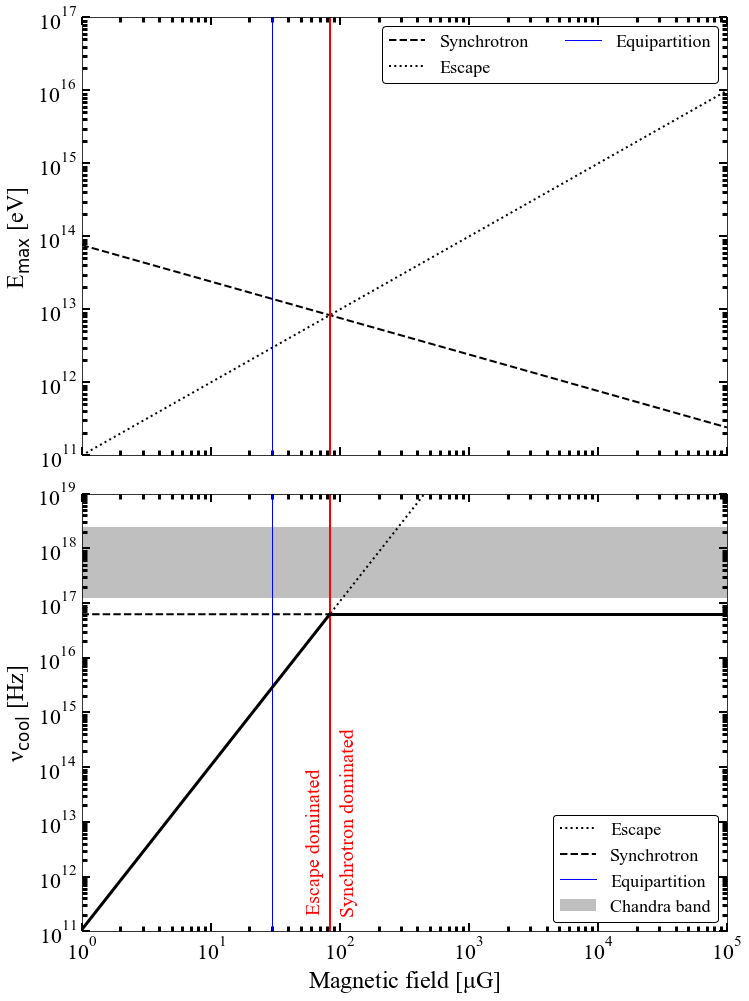

In [102]:
fig = plt.figure(figsize=(cm2inch(3*single_col),cm2inch(4*single_col)))

ax = fig.add_subplot(211)

ax.tick_params(labelsize=LS, width=2, length=8, axis='both', which='major', pad=5)
ax.tick_params(labelsize=LS, length=5, width=3, axis='both', which='minor', pad=5)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

ax.plot(B_axis, (C_sync * (B_axis**-0.5)).to(u.eV), 'k--', lw=2, label='Synchrotron')
ax.plot(B_axis, (C_escape * B_axis).to(u.eV), 'k:', lw=2, label='Escape')
ax.plot([B_equipartition.value, B_equipartition.value], [1,1e100], 'b-', lw=1, label='Equipartition')
ax.plot([B_t.value, B_t.value], [1,1e100], 'r-', lw=2)

ax.set_xlim(1e0, 1e5)
ax.set_ylim(1e11, 1e17)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xticklabels([])
ax.set_ylabel(r'$E_{\rm max}$ [eV]', fontsize=FS+2)

legend = ax.legend(loc=1, fontsize=FS-4, ncol=2, frameon=True, framealpha=1.0)
frame = legend.get_frame()
frame.set_edgecolor('black')

ax = fig.add_subplot(212)

ax.tick_params(labelsize=LS, width=2, length=8, axis='both', which='major', pad=5)
ax.tick_params(labelsize=LS, length=5, width=3, axis='both', which='minor', pad=5)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

ax.fill_between([1e-10, 1e10], [chandra_min, chandra_min], [chandra_max, chandra_max], facecolor='0.75', label='Chandra band')

# Here, we actually calculate the cooling break frequencies below and above B_T, as defined earlier:
ax.plot(B_axis, (nu_cool_factor * (C_escape**2.0) * (B_axis**3.0)).to(u.Hz), 'k:', lw=2, label='Escape')
ax.plot(B_axis, (nu_cool_factor * (C_sync**2.0) * (B_axis/B_axis)).to(u.Hz), 'k--', lw=2, label='Synchrotron')
ax.plot([B_t.value, B_t.value], [1,1e100], 'r-', lw=2)
ax.plot([B_equipartition.value, B_equipartition.value], [1,1e100], 'b-', lw=1, label='Equipartition')

ax.plot(B_axis_low, (nu_cool_factor * (C_escape**2.0) * (B_axis_low**3.0)).to(u.Hz), 'k-', lw=3)
ax.plot(B_axis_high, (nu_cool_factor * (C_sync**2.0) * (B_axis_high/B_axis_high)).to(u.Hz), 'k-', lw=3)

ax.set_xlim(1e0, 1e5)
ax.set_ylim(1e11, 1e19)
ax.set_xscale('log')
ax.set_yscale('log')

ax.text(5.5e1, 5.5e13, 'Escape dominated', fontsize=FS-2, color='r', rotation='90')
ax.text(1.01e2, 3e14, 'Synchrotron dominated', fontsize=FS-2, color='r', rotation='90')

ax.set_xlabel(r'Magnetic field [$\mu$G]', fontsize=FS+2)
ax.set_ylabel(r'$\nu_{\rm cool}$ [Hz]', fontsize=FS+2)

legend = ax.legend(loc=4, fontsize=FS-4, ncol=1, frameon=True, framealpha=1.0)
frame = legend.get_frame()
frame.set_edgecolor('black')

plt.tight_layout()
plt.savefig('NonThermalScenario/Emax_and_coolingbreak.pdf')

#### Model the synchotron SED for two spectral indices and two magnetic fields

We will calculate the synchrotron spectrum for $\alpha = 0.5$ and $\alpha = 0.7$, and for the equipartition and transitional magnetic field.

We will calculate 
$$F_{\rm sync}(E_{\gamma}) \propto \kappa_{\nu, \rm SSA} \int_{E_{\rm min}}^{E_{\rm max}} N(E) \left(\frac{E_{\gamma}}{E_c(E)}\right)^{4/3}e^{-\frac{E_{\gamma}}{E_c(E)}}dE$$

where $\kappa_{\nu, \rm SSA} = (1-e^{-\tau_\nu})/\tau_\nu$ and $\tau_\nu$ is given by Eq. 8.132 in Longair (2011). Finally, 

$$E_c(E) = \frac{3}{4\pi}\frac{ehB}{mc}\left(\frac{E}{mc^2}\right)^2 $$

In [104]:
# Defining the frequency of 1 keV
chandra_1keV = ((1.0 * u.keV) / (6.6260701e-34 * u.Joule * u.s)).to(u.Hz).value

In [105]:
# Defining a photon frequency axis:
nu_phot = 10**np.linspace(3, 21, 1000, endpoint=True) * u.Hz

In [108]:
def kappa_SSA_calc(kappa, B, p, nu_phot, DR):
    
    ### Calculate the optical depth and the SSA factor as a function of frequency:
    
    chi0 = (3.**0.5)*(cds.e**3.0)*c / (8.*(np.pi**2.)*cds.eps0*m_e)
    chi0 = chi0 * kappa * (B ** ((p+2.)/2.)) * b_p(p)
    chi0 = chi0 * (((3.*cds.e)/(2*np.pi*(m_e**3.0)*(c**4.0)))**(p/2.))
    chi_nu = (chi0 * (nu_phot**(-1.*(p+4.)/2))).to(1/u.m)

    tau_nu = chi_nu.to(1./u.m)*DR.to(u.m)

    # The loop below is to deal with python/numpy numerical accuracy:
    kappa_SSA = []
    for i in xrange(len(tau_nu)):
        # Note: the 1e-8 limit is where kappa_SSA ~ 0.9999994. The real issues arise when tau < 1e-14 or so. 
        if tau_nu[i] > 1e-8:
            kappa_SSA.append((1. - np.exp(-1.*tau_nu[i])) / tau_nu[i])
        else:
            kappa_SSA.append(1.)

    kappa_SSA = np.asarray(kappa_SSA)
    
    return kappa_SSA

In [109]:
# Defining b(p) to calculate kappa_SSA
def b_p(p):
    
    F1 = (np.pi**0.5)/(8.)
    F2 = scipy.special.gamma((3.*p + 22.)/12.)
    F3 = scipy.special.gamma((3.*p + 2.)/12.)
    F4 = scipy.special.gamma((p + 6.)/4.)
    F5 = scipy.special.gamma((p + 8.)/4.)
    
    return F1*F2*F3*F4/F5

We will now calculate four combinations of $\alpha$ and $B$, and then plot them:
- set 1: $\alpha = 0.5$, $B = B_{\rm eq}$
- set 2: $\alpha = 0.5$, $B = B_{\rm T}$
- set 3: $\alpha = 0.7$, $B = B_{\rm eq}$
- set 4: $\alpha = 0.7$, $B = B_{\rm T}$

In [112]:
# Set 1: 
alpha = 0.5
p = 2.*alpha+1
B = B_equipartition

################################################################################################################

# Calculate the maxmimum electron energy given the magnetic field
E_max = min([(C_sync * (B**-0.5)).to(u.eV), (C_escape * B).to(u.eV)])

# Then we need to find the E_max value in the E_elec array that is closest:
E_max_index = 0
while E_elec[E_max_index] < E_max:
    E_max_index = E_max_index+1
E_max = E_elec[E_max_index]

print E_max

################################################################################################################

# Calculate kappa, the normalisation of the electron number density distribution, which comes back in the 
# calculation of the SSA factor:
kappa = ((4.*np.pi*(D**2.)*Snu) / Vbowshock) * (4.*np.pi*cds.eps0*c*m_e) / ((3.**0.5)*(cds.e**3.)*B)
kappa = kappa * (((3.*cds.e*B)/(2.*np.pi*nu_obs*(m_e**3.)*(c**4.)))**(-1*(p-1.)/2.))
kappa = kappa.to(u.GeV**(p-1.) / u.m**3.)

# Calculating the SSA factor
kappa_SSA = kappa_SSA_calc(kappa, B, p, nu_phot, DR)

# Defining the electron energy axis for the numeric integration:
E_elec_integrated = E_elec[:E_max_index]
dE_elec_integrated = E_elec[1:E_max_index+1] - E_elec[:E_max_index]

# Calculate the critical energy as a function of the integrated energy. 
E_c = ((3./(4*np.pi)) * (cds.e * 6.6260701e-34 * u.Joule * u.s * B) / (m_e)) * ((E_elec_integrated/(m_e*c*c))**2.0)

# We first do one calculation, for the MKAT frequency, to fix the 
# normalisation; then we will continue with all other frequencies.

# Define the energy E = h*nu of the MeerKAT data and divide by the energy dependent critical energy:
E_obs = (nu_obs * 6.6260701e-34 * u.Joule * u.s).to(u.eV)
E_ratio_obs = E_obs.to(u.eV) / E_c.to(u.eV)

# Calculate the array with the integrands, and sum them:
integrand_obs = (E_elec_integrated**(-1.*p)) * (E_ratio_obs ** (4./3.)) * np.exp(-1.*E_ratio_obs) * dE_elec_integrated 
integral_obs = sum(integrand_obs)

# Calculate the numerical normalisation by comparing to the observed flux density:
N_numeric_sync = Snu.to(u.Jy) / integral_obs
N_numeric_sync

Fsync = []

# Now calculate the flux density at all photon frequencies, using the normalisation above:
for i in xrange(len(nu_phot)):
    
    E_phot = (nu_phot[i] * 6.6260701e-34 * u.Joule * u.s).to(u.eV)
    E_ratio = E_phot.to(u.eV) / E_c.to(u.eV)
    
    integrand = (E_elec_integrated**(-1.*p)) * (E_ratio ** (4./3.)) * np.exp(-1.*E_ratio) * dE_elec_integrated 
    integral = sum(integrand)
    
    Fsync_unabs = N_numeric_sync * integral
    Fsync.append((Fsync_unabs.to(u.Jy)).value * kappa_SSA[i])
    
Fsync1 = np.asarray(Fsync) * u.Jy

3.00939003445e+12 eV


In [113]:
# Set 2: 
alpha = 0.5
p = 2.*alpha+1
B = B_t

################################################################################################################

E_max = min([(C_sync * (B**-0.5)).to(u.eV), (C_escape * B).to(u.eV)])

# Then we need to find the E_max value in the E_elec array that is closest:
E_max_index = 0
while E_elec[E_max_index] < E_max:
    E_max_index = E_max_index+1
E_max = E_elec[E_max_index]

print E_max

################################################################################################################

kappa = ((4.*np.pi*(D**2.)*Snu) / Vbowshock) * (4.*np.pi*cds.eps0*c*m_e) / ((3.**0.5)*(cds.e**3.)*B)
kappa = kappa * (((3.*cds.e*B)/(2.*np.pi*nu_obs*(m_e**3.)*(c**4.)))**(-1*(p-1.)/2.))
kappa = kappa.to(u.GeV**(p-1.) / u.m**3.)

kappa_SSA = kappa_SSA_calc(kappa, B, p, nu_phot, DR)

E_elec_integrated = E_elec[:E_max_index]
dE_elec_integrated = E_elec[1:E_max_index+1] - E_elec[:E_max_index]

# Calculate the critical energy as a function of the integrated energy. 
E_c = ((3./(4*np.pi)) * (cds.e * 6.6260701e-34 * u.Joule * u.s * B) / (m_e)) * ((E_elec_integrated/(m_e*c*c))**2.0)

# Define the energy E = h*nu of the MeerKAT data and divide by the energy dependent critical energy:
E_obs = (nu_obs * 6.6260701e-34 * u.Joule * u.s).to(u.eV)
E_ratio_obs = E_obs.to(u.eV) / E_c.to(u.eV)

# Calculate the array with the integrands, and sum them:
integrand_obs = (E_elec_integrated**(-1.*p)) * (E_ratio_obs ** (4./3.)) * np.exp(-1.*E_ratio_obs) * dE_elec_integrated 
integral_obs = sum(integrand_obs)

# Calculate the numerical normalisation by comparing to the observed flux density:
N_numeric_sync = Snu.to(u.Jy) / integral_obs
N_numeric_sync

Fsync = []

for i in xrange(len(nu_phot)):
    
    E_phot = (nu_phot[i] * 6.6260701e-34 * u.Joule * u.s).to(u.eV)
    E_ratio = E_phot.to(u.eV) / E_c.to(u.eV)
    
    integrand = (E_elec_integrated**(-1.*p)) * (E_ratio ** (4./3.)) * np.exp(-1.*E_ratio) * dE_elec_integrated 
    integral = sum(integrand)
    
    Fsync_unabs = N_numeric_sync * integral
    Fsync.append((Fsync_unabs.to(u.Jy)).value * kappa_SSA[i])
    
Fsync2 = np.asarray(Fsync) * u.Jy

8.45136633068e+12 eV


In [114]:
# Set 3: 
alpha = 0.7
p = 2.*alpha+1
B = B_equipartition

################################################################################################################

E_max = min([(C_sync * (B**-0.5)).to(u.eV), (C_escape * B).to(u.eV)])

# Then we need to find the E_max value in the E_elec array that is closest:
E_max_index = 0
while E_elec[E_max_index] < E_max:
    E_max_index = E_max_index+1
E_max = E_elec[E_max_index]

################################################################################################################

kappa = ((4.*np.pi*(D**2.)*Snu) / Vbowshock) * (4.*np.pi*cds.eps0*c*m_e) / ((3.**0.5)*(cds.e**3.)*B)
kappa = kappa * (((3.*cds.e*B)/(2.*np.pi*nu_obs*(m_e**3.)*(c**4.)))**(-1*(p-1.)/2.))
kappa = kappa.to(u.GeV**(p-1.) / u.m**3.)

kappa_SSA = kappa_SSA_calc(kappa, B, p, nu_phot, DR)

E_elec_integrated = E_elec[:E_max_index]
dE_elec_integrated = E_elec[1:E_max_index+1] - E_elec[:E_max_index]

# Calculate the critical energy as a function of the integrated energy. 
E_c = ((3./(4*np.pi)) * (cds.e * 6.6260701e-34 * u.Joule * u.s * B) / (m_e)) * ((E_elec_integrated/(m_e*c*c))**2.0)

# Define the energy E = h*nu of the MeerKAT data and divide by the energy dependent critical energy:
E_obs = (nu_obs * 6.6260701e-34 * u.Joule * u.s).to(u.eV)
E_ratio_obs = E_obs.to(u.eV) / E_c.to(u.eV)

# Calculate the array with the integrands, and sum them:
integrand_obs = (E_elec_integrated**(-1.*p)) * (E_ratio_obs ** (4./3.)) * np.exp(-1.*E_ratio_obs) * dE_elec_integrated 
integral_obs = sum(integrand_obs)

# Calculate the numerical normalisation by comparing to the observed flux density:
N_numeric_sync = Snu.to(u.Jy) / integral_obs
N_numeric_sync

Fsync = []

for i in xrange(len(nu_phot)):
    
    E_phot = (nu_phot[i] * 6.6260701e-34 * u.Joule * u.s).to(u.eV)
    E_ratio = E_phot.to(u.eV) / E_c.to(u.eV)
    
    integrand = (E_elec_integrated**(-1.*p)) * (E_ratio ** (4./3.)) * np.exp(-1.*E_ratio) * dE_elec_integrated 
    integral = sum(integrand)
    
    Fsync_unabs = N_numeric_sync * integral
    Fsync.append((Fsync_unabs.to(u.Jy)).value * kappa_SSA[i])
    
Fsync3 = np.asarray(Fsync) * u.Jy

In [115]:
# Set 4: 
alpha = 0.7
p = 2.*alpha+1
B = B_t

################################################################################################################

E_max = min([(C_sync * (B**-0.5)).to(u.eV), (C_escape * B).to(u.eV)])

# Then we need to find the E_max value in the E_elec array that is closest:
E_max_index = 0
while E_elec[E_max_index] < E_max:
    E_max_index = E_max_index+1
E_max = E_elec[E_max_index]

################################################################################################################

kappa = ((4.*np.pi*(D**2.)*Snu) / Vbowshock) * (4.*np.pi*cds.eps0*c*m_e) / ((3.**0.5)*(cds.e**3.)*B)
kappa = kappa * (((3.*cds.e*B)/(2.*np.pi*nu_obs*(m_e**3.)*(c**4.)))**(-1*(p-1.)/2.))
kappa = kappa.to(u.GeV**(p-1.) / u.m**3.)

kappa_SSA = kappa_SSA_calc(kappa, B, p, nu_phot, DR)

E_elec_integrated = E_elec[:E_max_index]
dE_elec_integrated = E_elec[1:E_max_index+1] - E_elec[:E_max_index]

# Calculate the critical energy as a function of the integrated energy. 
E_c = ((3./(4*np.pi)) * (cds.e * 6.6260701e-34 * u.Joule * u.s * B) / (m_e)) * ((E_elec_integrated/(m_e*c*c))**2.0)

# Define the energy E = h*nu of the MeerKAT data and divide by the energy dependent critical energy:
E_obs = (nu_obs * 6.6260701e-34 * u.Joule * u.s).to(u.eV)
E_ratio_obs = E_obs.to(u.eV) / E_c.to(u.eV)

# Calculate the array with the integrands, and sum them:
integrand_obs = (E_elec_integrated**(-1.*p)) * (E_ratio_obs ** (4./3.)) * np.exp(-1.*E_ratio_obs) * dE_elec_integrated 
integral_obs = sum(integrand_obs)

# Calculate the numerical normalisation by comparing to the observed flux density:
N_numeric_sync = Snu.to(u.Jy) / integral_obs
N_numeric_sync

Fsync = []

for i in xrange(len(nu_phot)):
    
    E_phot = (nu_phot[i] * 6.6260701e-34 * u.Joule * u.s).to(u.eV)
    E_ratio = E_phot.to(u.eV) / E_c.to(u.eV)
    
    integrand = (E_elec_integrated**(-1.*p)) * (E_ratio ** (4./3.)) * np.exp(-1.*E_ratio) * dE_elec_integrated 
    integral = sum(integrand)
    
    Fsync_unabs = N_numeric_sync * integral
    Fsync.append((Fsync_unabs.to(u.Jy)).value * kappa_SSA[i])
    
Fsync4 = np.asarray(Fsync) * u.Jy

#### Recreating Figure 9 from the paper

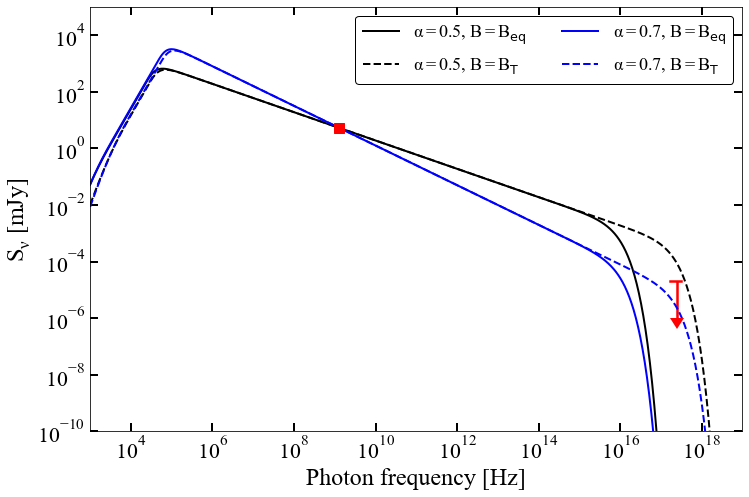

In [116]:
fig = plt.figure(figsize=(cm2inch(3*single_col),cm2inch(2*single_col)))
ax = fig.add_subplot(111)

ax.tick_params(labelsize=LS, width=2, length=8, axis='both', which='major', pad=5)
ax.tick_params(labelsize=LS, length=5, width=3, axis='both', which='minor', pad=5)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

ax.plot(nu_phot, Fsync1.to(u.mJy), 'k-', lw=2, label=r'$\alpha=0.5$, $B=B_{\rm eq}$')
ax.plot(nu_phot, Fsync2.to(u.mJy), 'k--', lw=2, label=r'$\alpha=0.5$, $B=B_{\rm T}$')

ax.plot(nu_phot, Fsync3.to(u.mJy), 'b-', lw=2, label=r'$\alpha=0.7$, $B=B_{\rm eq}$')
ax.plot(nu_phot, Fsync4.to(u.mJy), 'b--', lw=2, label=r'$\alpha=0.7$, $B=B_{\rm T}$')

ax.plot(nu_obs.to(u.Hz), Snu, 'rs', ms=10)
ax.errorbar([chandra_1keV], [2.1e-5], xerr=[0.], yerr=[2e-5], uplims=True, fmt='ro', lw=2.5, ms=0, capsize=7, capthick=0)
ax.plot([0.7*chandra_1keV, 1.3*chandra_1keV], [2.1e-5, 2.1e-5], 'r-', lw=2.5)

ax.set_xlim(1e3, 1e19)
ax.set_ylim(1e-10, 1e5)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('Photon frequency [Hz]', fontsize=FS+2)
ax.set_ylabel(r'$S_{\nu}$ [mJy]', fontsize=FS+2)

legend = ax.legend(loc=1, fontsize=FS-4, ncol=2, frameon=True, framealpha=1.0)
frame = legend.get_frame()
frame.set_edgecolor('black')

plt.tight_layout()
plt.savefig('NonThermalScenario/SED.pdf')

#### Calculating the injection efficiency as a function of magnetic field and spectral index

As detailed in the main paper, we define the injection efficiency as 

$$\eta_e \equiv \frac{\epsilon_e}{L_{\rm wind}}$$

Conceptually, this means we compare the available wind kinteic power to the energy in electrons.

These top is given by:

$$\epsilon_e = V_{\rm bowshock} \int_{E_{\rm min}}^{E_{\rm max}} Q(E) E dE$$

where $Q(E)$ is the injection spectrum. Therefore 

$$\eta_e = \frac{8\pi R_0^3}{3\dot{M}_{\rm wind} v^2_{\infty}} \int_{E_{\rm min}}^{E_{\rm max}} Q(E) E dE$$

The question then becomes: how to calculate the injection spectrum of accelerated electrons. Assuming a steady state, we know that the injection should balance both radiative and diffusive losses, so we can write (following Del Valle et al. 2012):

$$Q(E) = \frac{\delta}{\delta E}\left[\left(\frac{dE}{dt}\right)_{\rm rad} N(E)\right]+ \frac{N(E)}{t_{\rm esc}}$$

We can also add the assumption that the escape time scale is significantly shorter than all cooling time scales at the energies relevant to the radio band: then, the above equation reduces to:

$$Q(E) \approx \frac{N(E)}{t_{\rm esc}}$$

We already know that $N(E) = \kappa E^{-p}$, and that $\kappa$ can be derived from the measured quantities via

$$\kappa = \frac{4\pi D^2 S_{\nu}}{V_{\rm bowshock}} \frac{4\pi\epsilon_0 c m_e}{\sqrt{3}e^3 B a(p)} \left(\frac{3eB}{2\pi\nu m_e^3 c^4}\right)^{-(p-1)/2}$$

Plugging all of that into the equation for electron acceleration efficiency yields (with the approximation from the Q(E) simplification):

$$\eta_e \approx \frac{128\pi^3 R_0^3 D^2 S_\nu \epsilon_0 c m_e}{3\sqrt(3)\dot{M}_{\rm wind} v_{\infty} \Delta V_{\rm bowshock} e^3 B a(p)} \left(\frac{3eB}{2\pi\nu m_e^3 c^4}\right)^{-(p-1)/2} \int_{E_{\rm min}}^{E_{\rm max}} E^{1-p}dE$$

To calculate this integral, we will define two functions:

In [119]:
def Integral(p, Emin, Emax):
    if p == 2.:
        return np.log(Emax/Emin)
    else:
        return ((1./(2.-p)) * (Emax**(2.-p) - Emin**(2.-p))).to(u.J**(2.-p))

def eta_e(B, p, R0, D, Snu_tot, Mdot, vwind, DR, Vbs, nu_obs, Emin, Emax):
    
    F1 = 128.*(np.pi**3)*(R0**3.)*(D**2.)*Snu_tot*cds.eps0*c*m_e
    F2 = (3.**1.5)*Mdot*vwind*DR*Vbs*(cds.e**3)*B*a_p(p)
    
    F12 = (F1/F2).to(u.J**-1)
        
    F3 = 3.*cds.e*B / (2.*np.pi*nu_obs*(m_e**3)*(c**4))    
    F3 = F3**(-1.*(p-1.)/2.)
    F3 = F3.to(u.J**(p-1.)) 
        
    F4 = Integral(p, Emin, Emax)
        
    try:
        return (F12*F3*F4).to(u.s/u.s)
    except:
        return (F12*F3*F4).value
        # Note: here, we have to use .value, after calculating all in energies; this is because otherwise, 
        # for odd powers p, the accuracy is not high enough and it returns 
        # something with units like J**0.00000000000000000000000001.

With the above functions, we can calculate the injection efficiency as a function of magnetic field. We will do so for $\alpha = 0.5$ ($p = 2$) and $\alpha = 0.7$ ($p = 2.4$):

In [133]:
eta_plotted_VelaX1_p20 = eta_e(B=B_axis, p=2.0, R0=R0, D=D, Snu_tot=Snu, Mdot=Mdot, vwind=vwind, DR=DR, Vbs=Vbowshock, 
                              nu_obs=nu_obs, Emin=1e6*u.eV, Emax=E_max)

eta_plotted_VelaX1_p24 = eta_e(B=B_axis, p=2.4, R0=R0, D=D, Snu_tot=Snu, Mdot=Mdot, vwind=vwind, DR=DR, Vbs=Vbowshock, 
                               nu_obs=nu_obs, Emin=1e6*u.eV, Emax=E_max)

It is, however, also interesting to consider, for a given magnetic field, how it depends on the spectral index. We calculate that below:

In [134]:
# Defining an axis in radio spectral index:
alpha_axis = np.linspace(0.0, 1.0, 200, endpoint=True)

# Calculation for the equipartition magnetic field:
alpha_plotted1 = []
eta_vs_alpha1 = []
for i in xrange(len(alpha_axis)):
    try:
        eta_vs_alpha_i = eta_e(B=B_equipartition, p=2.*alpha_axis[i]+1., R0=R0, D=D, Snu_tot=Snu, Mdot=Mdot, vwind=vwind, DR=DR, Vbs=Vbowshock, nu_obs=nu_obs, Emin=1e6*u.eV, Emax=E_max)
        eta_vs_alpha1.append(eta_vs_alpha_i)
        alpha_plotted1.append(alpha_axis[i])
    except:
        pass

# Calculation for the maximum magnetic field of 46 uG. 
alpha_plotted2 = []
eta_vs_alpha2 = []
for i in xrange(len(alpha_axis)):
    try:
        eta_vs_alpha_i = eta_e(B=46*u.microGauss, p=2.*alpha_axis[i]+1., R0=R0, D=D, Snu_tot=Snu, Mdot=Mdot, vwind=vwind, DR=DR, Vbs=Vbowshock, nu_obs=nu_obs, Emin=1e6*u.eV, Emax=E_max)
        eta_vs_alpha2.append(eta_vs_alpha_i)
        alpha_plotted2.append(alpha_axis[i])
    except:
        pass

Then we can go along and plot the efficiency both as a function of magnetic field, and as function of $\alpha$

#### Recreating Figure 10 from the paper:

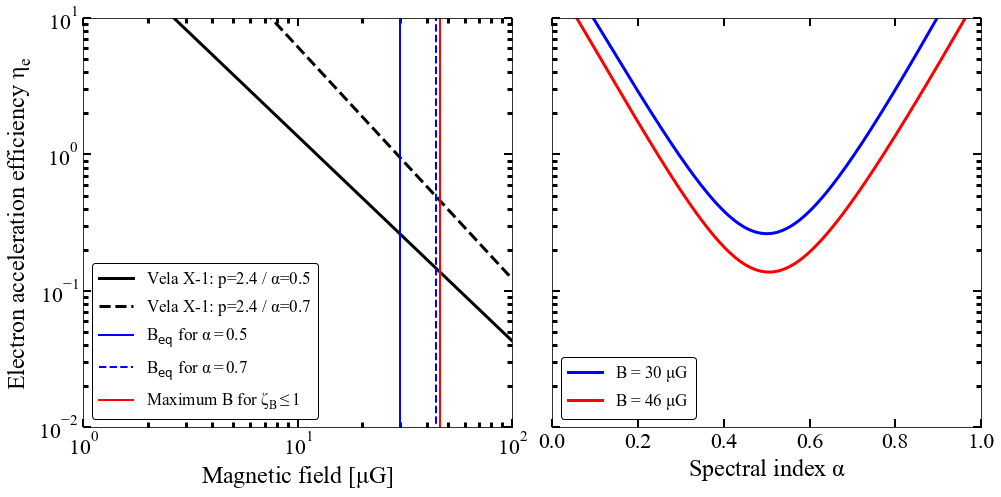

In [135]:
fig = plt.figure(figsize=(cm2inch(4*single_col),cm2inch(2*single_col)))
ax = fig.add_subplot(121)

ax.tick_params(labelsize=LS, width=2, length=8, axis='both', which='major', pad=5)
ax.tick_params(labelsize=LS, length=5, width=3, axis='both', which='minor', pad=5)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

ax.plot(B_axis, eta_plotted_VelaX1_p20, 'k-', lw=3, label=r'Vela X-1: p='+str(p)+r' / $\alpha$='+str(alpha_thin))
ax.plot(B_axis, eta_plotted_VelaX1_p24, 'k--', lw=3, label=r'Vela X-1: p=2.4 / $\alpha$=0.7')

ax.plot([B_equipartition.value, B_equipartition.value], [1e-10, 1e10], 'b-', lw=2, label=r'$B_{\rm eq}$ for $\alpha=0.5$')
ax.plot([44., 44.], [1e-10, 1e10], 'b--', lw=2, label=r'$B_{\rm eq}$ for $\alpha=0.7$')
ax.plot([46., 46.], [1e-10, 1e10], 'r-', lw=2, label=r'Maximum B for $\zeta_B \leq 1$')

ax.set_xlim(1e0, 1e2) 
ax.set_ylim(1e-2, 1e1)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'Magnetic field [$\mu$G]', fontsize=FS+2)
ax.set_ylabel(r'Electron acceleration efficiency $\eta_e$', fontsize=FS+2)

legend = ax.legend(loc=3, fontsize=FS-5, ncol=1, frameon=True, framealpha=1.0)
frame = legend.get_frame()
frame.set_edgecolor('black')

############################################################################################################

ax = fig.add_subplot(122)

ax.tick_params(labelsize=LS, width=2, length=8, axis='both', which='major', pad=5)
ax.tick_params(labelsize=LS, length=5, width=3, axis='both', which='minor', pad=5)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

ax.plot(alpha_plotted1, eta_vs_alpha1, 'b-', lw=3, label=r'B = 30 $\mu$G')
ax.plot(alpha_plotted2, eta_vs_alpha2, 'r-', lw=3, label=r'B = 46 $\mu$G')

ax.set_xlim(0., 1.)
ax.set_ylim(1e-2, 1e1)
ax.set_yscale('log')

legend = ax.legend(loc=3, fontsize=FS-5, ncol=1, frameon=True, framealpha=1.0)
frame = legend.get_frame()
frame.set_edgecolor('black')

ax.set_xlabel(r'Spectral index $\alpha$', fontsize=FS+2)
ax.set_yticklabels([])

plt.tight_layout()
plt.savefig('NonThermalScenario/eta_vs_B_and_eta_vs_alpha.pdf')

## Step 10: considering NVSS non-detections

Using the above equations, we can also invert the question: instead of calculating the $\eta_e$ required to explain the observed flux density, we can predict the flux density for assumed source parameters and injection efficiency. Below we will do so, for a set of NVSS-non-detected runaway star bow shocks.

In [137]:
def Snu_calc(B, p, R0, D, eta_e, Mdot, vwind, DR, Vbs, nu_obs, Emin, Emax):
    
    F1 = 128.*(np.pi**3)*(R0**3.)*(D**2.)*cds.eps0*c*m_e
    F2 = (3.**1.5)*Mdot*vwind*DR*Vbs*(cds.e**3)*B*a_p(p)
    
    F21 = F2 / F1
    
    F3 = 3.*cds.e*B / (2.*np.pi*nu_obs*(m_e**3)*(c**4))    
    F3 = F3**(-1.*(p-1.)/2.)
    F3 = F3.to(u.J**(p-1.)) 
    
    F4 = Integral(p, Emin, Emax)
    
    return (eta_e * F21 / (F3 * F4)).to(u.mJy)

In [141]:
# For the case of B = 100 uG: see the main text for all details and references for the stellar properties.
# We also assume a high, 10% injection efficiency. The bow shock volume V_BS corresponds to the volume of 
# a single NVSS beam with depth equal to the bow shock width, located at the source distance. Finally, we assume 
# alpha = 0.5, optimizing the flux density.
print 'HIP 16518:', Snu_calc(B=100.*u.microGauss, p=2.0, R0=0.13*u.pc, D=0.650*u.kpc, eta_e=0.1, 
                             Mdot=6.0e-9*u.solMass/u.yr, vwind=500*u.km/u.s, DR=0.19*u.pc, Vbs=(np.pi*0.19*u.pc*((0.142*u.pc)**2.)),
                             nu_obs=1.4*u.GHz, Emin=1e6*u.eV, Emax=1e12*u.eV)

print 'HIP 34536', Snu_calc(B=100.*u.microGauss, p=2.0, R0=1.5*u.pc, D=1.293*u.kpc, eta_e=0.1, 
                            Mdot=1.9e-7*u.solMass/u.yr, vwind=2456.*u.km/u.s, DR=1.13*u.pc, Vbs=(np.pi*1.13*u.pc*((0.282*u.pc)**2.)),
                            nu_obs=1.4*u.GHz, Emin=1e6*u.eV, Emax=1e12*u.eV)

print 'HIP 78401', Snu_calc(B=100.*u.microGauss, p=2.0, R0=0.39*u.pc, D=0.224*u.kpc, eta_e=0.1, 
                            Mdot=1.4e-7*u.solMass/u.yr, vwind=1100.*u.km/u.s, DR=0.13*u.pc, Vbs=(np.pi*0.13*u.pc*((0.0488*u.pc)**2.)), 
                            nu_obs=1.4*u.GHz, Emin=1e6*u.eV, Emax=1e12*u.eV)

print 'HIP 97796', Snu_calc(B=100.*u.microGauss, p=2.0, R0=3.84*u.pc, D=2.2*u.kpc, eta_e=0.1, 
                            Mdot=5.0e-7*u.solMass/u.yr, vwind=1980.*u.km/u.s, DR=1.60*u.pc, Vbs=(np.pi*1.60*u.pc*((0.48*u.pc)**2.)), 
                            nu_obs=1.4*u.GHz, Emin=1e6*u.eV, Emax=1e12*u.eV)

HIP 16518: 1.21793094212 mJy
HIP 34536 4.34750939295 mJy
HIP 78401 1.07803162288 mJy
HIP 97796 1.10304413251 mJy


In [142]:
# For the case of B = 50 uG: same as above in other properties.
print 'HIP 16518:', Snu_calc(B=50.*u.microGauss, p=2.0, R0=0.13*u.pc, D=0.650*u.kpc, eta_e=0.1, 
                             Mdot=6.0e-9*u.solMass/u.yr, vwind=500*u.km/u.s, DR=0.19*u.pc, Vbs=(np.pi*0.19*u.pc*((0.142*u.pc)**2.)),
                             nu_obs=1.4*u.GHz, Emin=1e6*u.eV, Emax=1e12*u.eV)

print 'HIP 34536', Snu_calc(B=50.*u.microGauss, p=2.0, R0=1.5*u.pc, D=1.293*u.kpc, eta_e=0.1, 
                            Mdot=1.9e-7*u.solMass/u.yr, vwind=2456.*u.km/u.s, DR=1.13*u.pc, Vbs=(np.pi*1.13*u.pc*((0.282*u.pc)**2.)),
                            nu_obs=1.4*u.GHz, Emin=1e6*u.eV, Emax=1e12*u.eV)

print 'HIP 78401', Snu_calc(B=50.*u.microGauss, p=2.0, R0=0.39*u.pc, D=0.224*u.kpc, eta_e=0.1, 
                            Mdot=1.4e-7*u.solMass/u.yr, vwind=1100.*u.km/u.s, DR=0.13*u.pc, Vbs=(np.pi*0.13*u.pc*((0.0488*u.pc)**2.)), 
                            nu_obs=1.4*u.GHz, Emin=1e6*u.eV, Emax=1e12*u.eV)

print 'HIP 97796', Snu_calc(B=50.*u.microGauss, p=2.0, R0=3.84*u.pc, D=2.2*u.kpc, eta_e=0.1, 
                            Mdot=5.0e-7*u.solMass/u.yr, vwind=1980.*u.km/u.s, DR=1.60*u.pc, Vbs=(np.pi*1.60*u.pc*((0.48*u.pc)**2.)), 
                            nu_obs=1.4*u.GHz, Emin=1e6*u.eV, Emax=1e12*u.eV)

HIP 16518: 0.430603614094 mJy
HIP 34536 1.53707668651 mJy
HIP 78401 0.381141735437 mJy
HIP 97796 0.389984993024 mJy


We can do a similar exercise for the thermal scenario, since the E-BOSS catalogue lists ISM densities for all stars. Here, we should again use the equations used before, to predicts the flux density given the temperature and electron number density. We assume a high factor of 10 density increase in the shock, and consider $T = 10^3$ K and $T = 10^4$ K.

In [143]:
def Snu_calc_th(T_bs, n_ism_bs, D, Vbs, nu_obs=1.4*u.GHz):

    kappa_star_nu = 6.8e-38 * u.erg * u.cm**-3 * u.s**-1 * u.Hz**-1
    kappa_star_nu = kappa_star_nu *(T_bs.value**-0.5) * gaunt(nu_obs, T_bs, 1.0)
    kappa_star_nu = kappa_star_nu * (n_ism_bs.to(u.cm**-3).value**2)

    return (kappa_star_nu * Vbs / (4*np.pi*(D**2))).to(u.mJy)

In [145]:
 # The density enhancement factor
A = 10.

In [146]:
# The case for T = 10^4 K:
print 'HIP 16518:', Snu_calc_th(T_bs=1.0e4*u.Kelvin, n_ism_bs=A*0.2*(u.cm**-3), D=0.650*u.kpc, 
                                Vbs=(np.pi*0.19*u.pc*((0.142*u.pc)**2.)), nu_obs=1.4*u.GHz)


print 'HIP 34536:', Snu_calc_th(T_bs=1.0e4*u.Kelvin, n_ism_bs=A*0.01*(u.cm**-3), D=1.293*u.kpc, 
                                Vbs=(np.pi*1.13*u.pc*((0.282*u.pc)**2.)), nu_obs=1.4*u.GHz)



print 'HIP 78401:', Snu_calc_th(T_bs=1.0e4*u.Kelvin, n_ism_bs=A*2.0*(u.cm**-3), D=0.224*u.kpc, 
                                Vbs=(np.pi*0.13*u.pc*((0.0488*u.pc)**2.)), nu_obs=1.4*u.GHz)


print 'HIP 97796:', Snu_calc_th(T_bs=1.0e4*u.Kelvin, n_ism_bs=A*0.02*(u.cm**-3), D=2.2*u.kpc, 
                                Vbs=(np.pi*1.60*u.pc*((0.48*u.pc)**2.)), nu_obs=1.4*u.GHz)

HIP 16518: 0.0121983719962 mJy
HIP 34536: 0.00018076648609 mJy
HIP 78401: 0.830013691776 mJy
HIP 97796: 0.00102460245612 mJy


In [147]:
# The case for T = 10^3 K:
print 'HIP 16518:', Snu_calc_th(T_bs=1.0e3*u.Kelvin, n_ism_bs=A*0.2*(u.cm**-3), D=0.650*u.kpc, 
                                Vbs=(np.pi*0.19*u.pc*((0.142*u.pc)**2.)), nu_obs=1.4*u.GHz)


print 'HIP 34536:', Snu_calc_th(T_bs=1.0e3*u.Kelvin, n_ism_bs=A*0.01*(u.cm**-3), D=1.293*u.kpc, 
                                Vbs=(np.pi*1.13*u.pc*((0.282*u.pc)**2.)), nu_obs=1.4*u.GHz)



print 'HIP 78401:', Snu_calc_th(T_bs=1.0e3*u.Kelvin, n_ism_bs=A*2.0*(u.cm**-3), D=0.224*u.kpc, 
                                Vbs=(np.pi*0.13*u.pc*((0.0488*u.pc)**2.)), nu_obs=1.4*u.GHz)


print 'HIP 97796:', Snu_calc_th(T_bs=1.0e3*u.Kelvin, n_ism_bs=A*0.02*(u.cm**-3), D=2.2*u.kpc, 
                                Vbs=(np.pi*1.60*u.pc*((0.48*u.pc)**2.)), nu_obs=1.4*u.GHz)

HIP 16518: 0.0271173800953 mJy
HIP 34536: 0.000401849813509 mJy
HIP 78401: 1.84514759602 mJy
HIP 97796: 0.00227772478637 mJy
